In [1]:
# read j3 wrf ts files

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils_solar import Tower
from mmctools.helper_functions import calc_wind, power_spectral_density, calc_spectra
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram, plot_spectrum
import matplotlib.colors as mcolors
import re

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd

# time step of wrf runs
d02_wrf_dt = 10
d03_wrf_dt = 2
d04_wrf_dt = 0.4

# run nickname, tower name & domain, time step, spin up time in hour
sim_dict = {'meso': ['c1.d02', d02_wrf_dt, np.timedelta64(12, 'h')], 
            'les200m': ['c1.d03', d03_wrf_dt, np.timedelta64(2, 'h')], 
            'les40m': ['c1.d04', d04_wrf_dt, np.timedelta64(1, 'h')]}

# derive spectra every x duration
spectra_window = '10min'
# average all the spectra every y duration
spectra_avg_freq = '1h'
spectra_avg_time = np.timedelta64(int(re.findall('\d+', spectra_avg_freq)[0]), 
                                  re.findall('[a-z]+', spectra_avg_freq)[0])

# les_spinup = np.timedelta64(1, 'h')

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

runs_list = list(data_dir_df.index)[:-1]

# 1 obs height in m, to match wrf's heights
share_height = [4, 25, 60]

In [2]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

def read_1wrf_ts(eval_date, sim, run):
    
    col = data_dir_df[eval_date]
    sim_val = sim_dict[sim]

    # # simulation start time
    wrf_start = col['wrf_start']
    
    wrf_file_path = wrf_runs_dir+col[run]+'/z_ts/z.'+sim_val[0]
    wrf_tower = Tower(wrf_file_path)

    wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, sim_val[1])
    wrf_ds['wspd'], wrf_ds['wdir'] = calc_wind(wrf_ds)
    
    return wrf_ds

def get_obs_ds(hgt, dt): 
    
    if hgt == 4:
        nc_tail = ''
    else:
        nc_tail = '.custom'
        
    obs_nc = obs_dir+'sgpco2flxwind'+str(hgt)+'mC1.a1/sgpco2flxwind'\
        +str(hgt)+'mC1.a1.'+eval_date.replace('-', '')+'.000000'+nc_tail+'.nc'
        
    obs_ds = xr.open_mfdataset(obs_nc)

    obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

    obs_ds = obs_ds.sel(time=eval_date)
    
    obs_ds = obs_ds.resample(time=str(dt)+'S').nearest()
    
    return obs_ds

def get_obs_spectra(obs_ds, time_start, time_end, spectra_window):
    
    obs_spectra = calc_spectra(obs_ds.sel(time=slice(time_start, time_end)),
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                           window_length=spectra_window,
                          )
    
    return obs_spectra

def get_wrf_spectra(wrf_ds, time_start, time_end, spectra_window):
    
    wrf_spectra = calc_spectra(wrf_ds.sel(datetime=slice(time_start, time_end)),
                              var_oi='wspd',
                              spectra_dim='datetime',
                              window='hamming',
                                level_dim='height',
                               window_length=spectra_window,
                              )
    
    return wrf_spectra

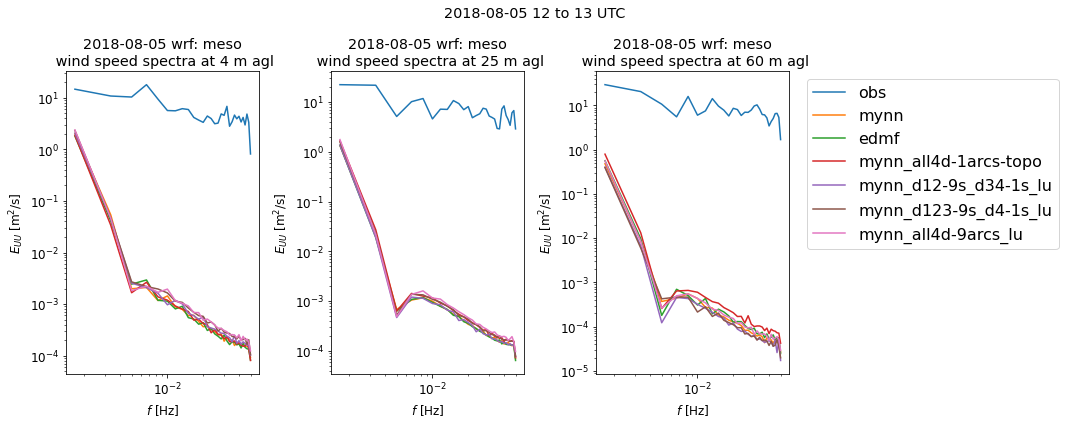

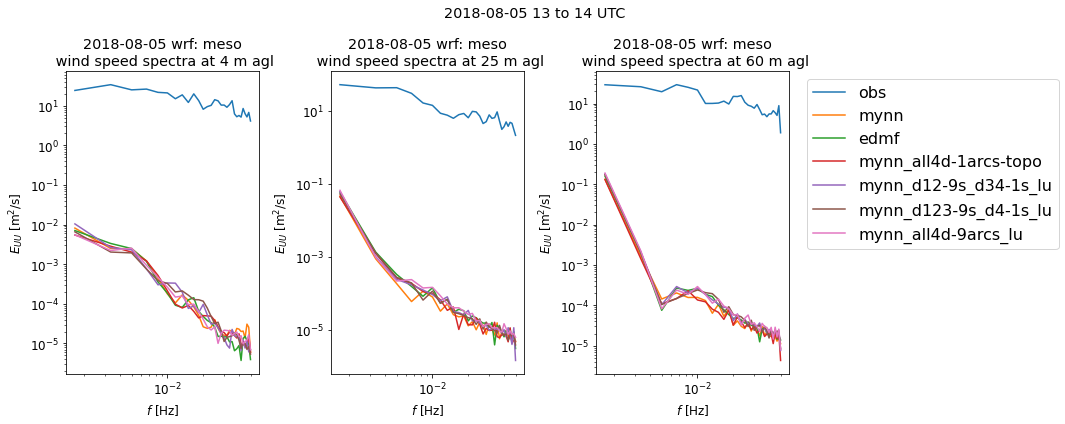

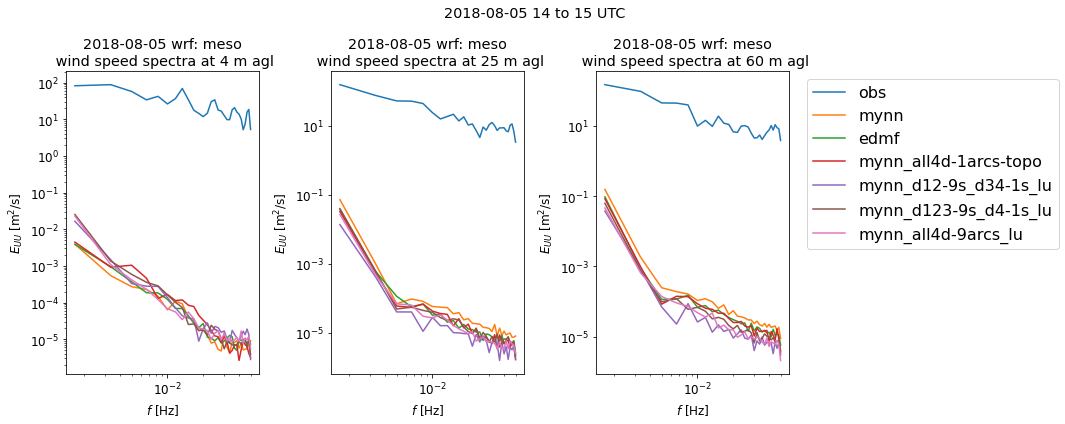

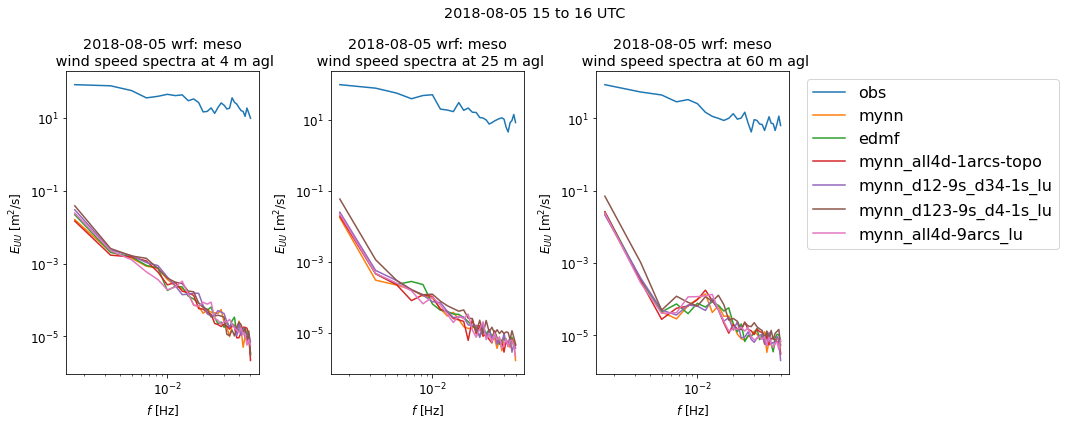

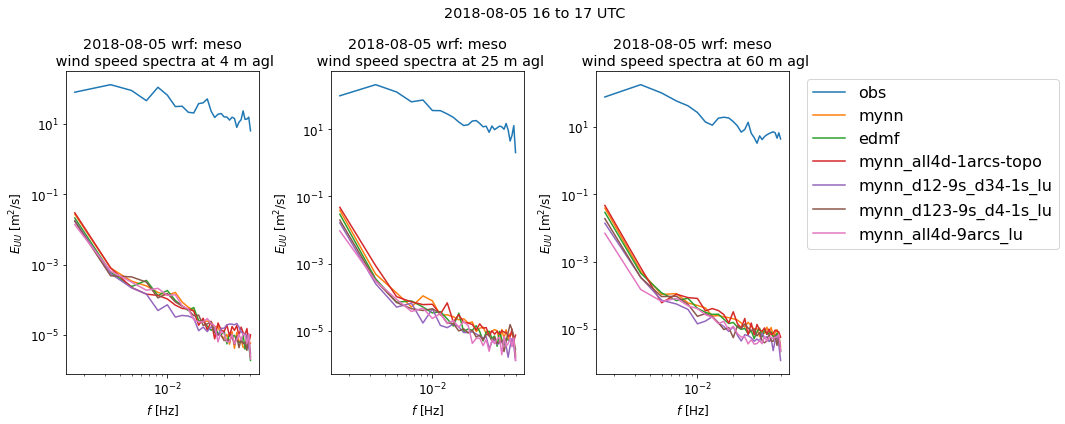

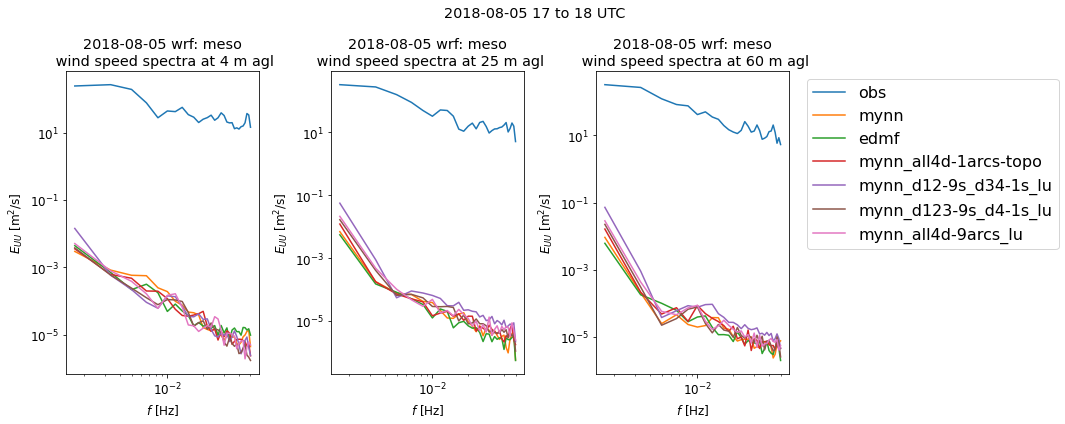

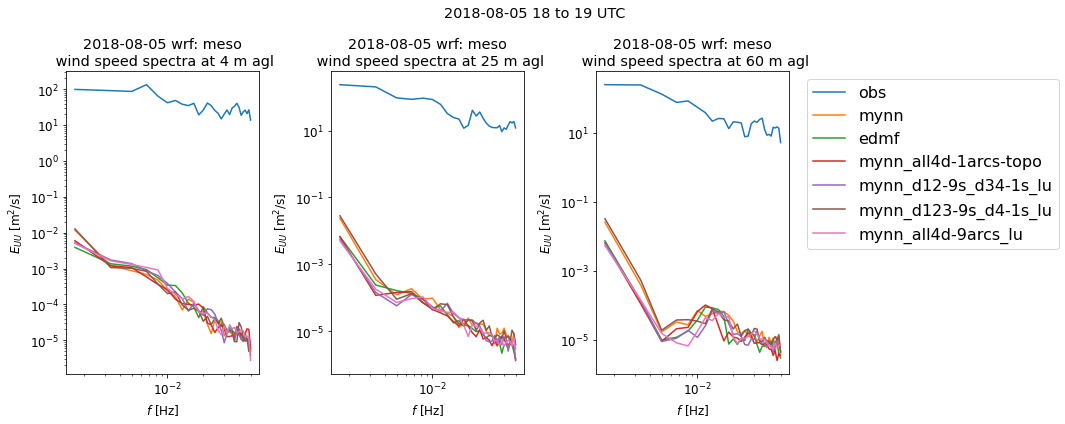

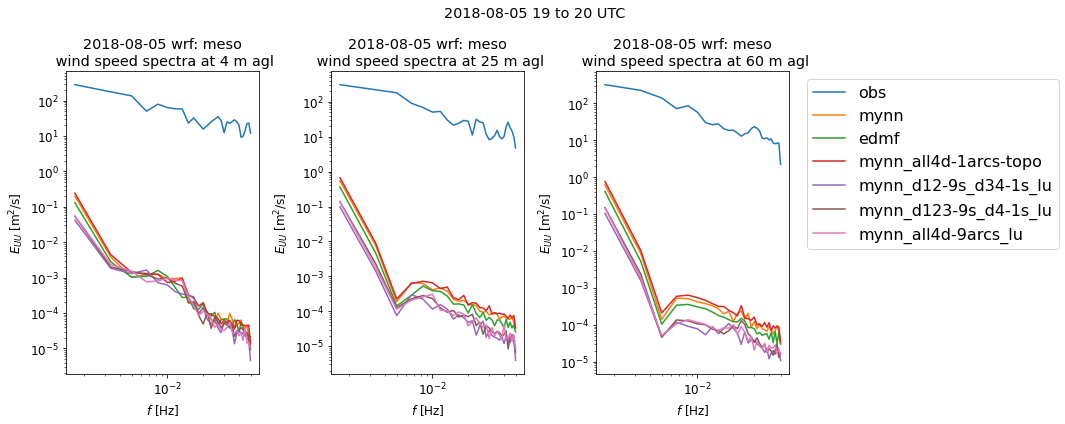

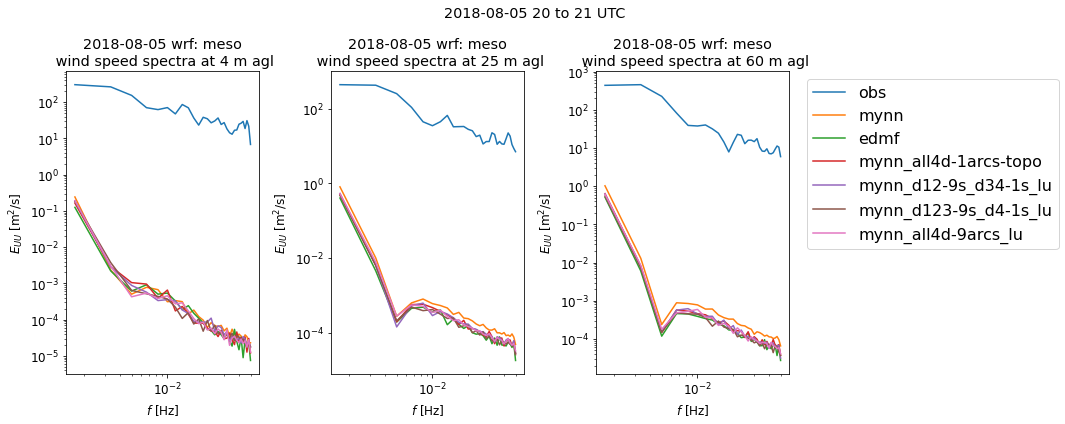

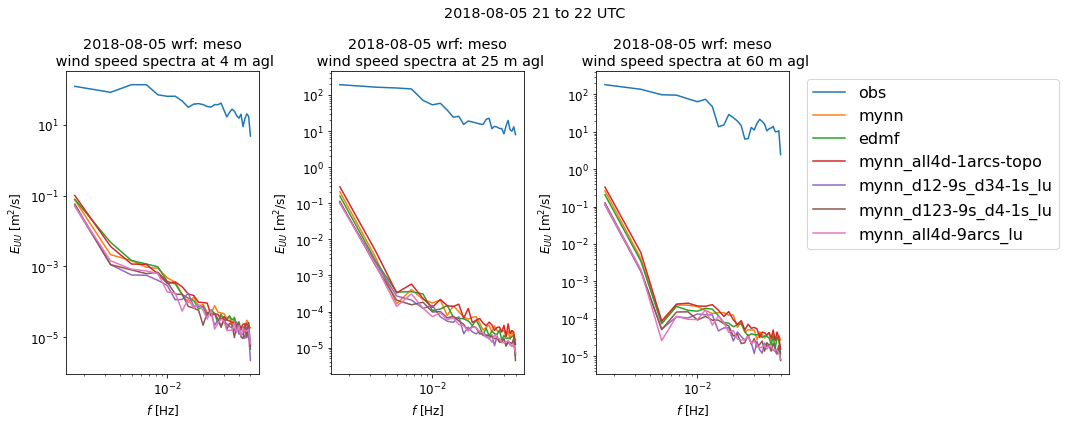

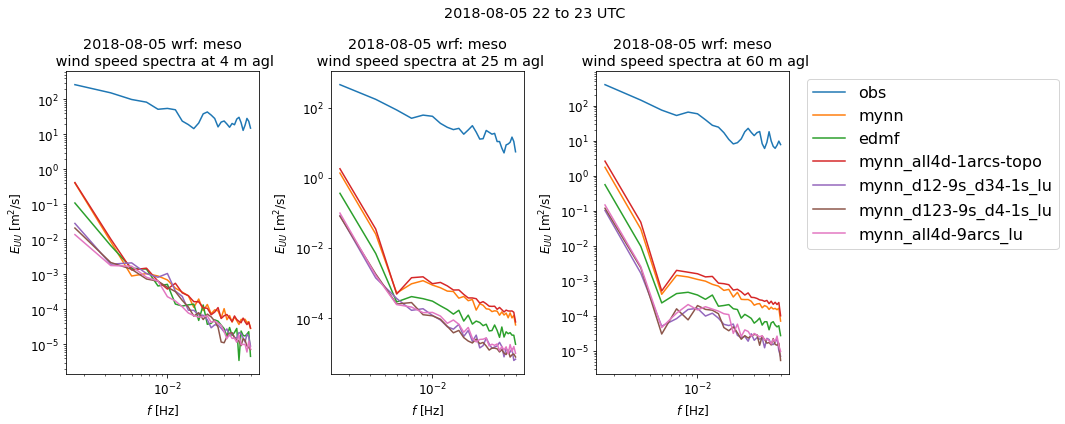

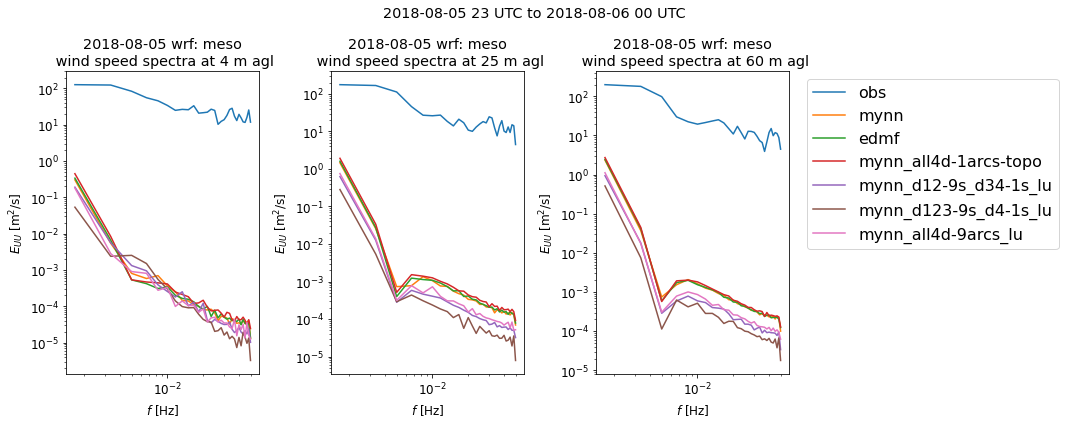

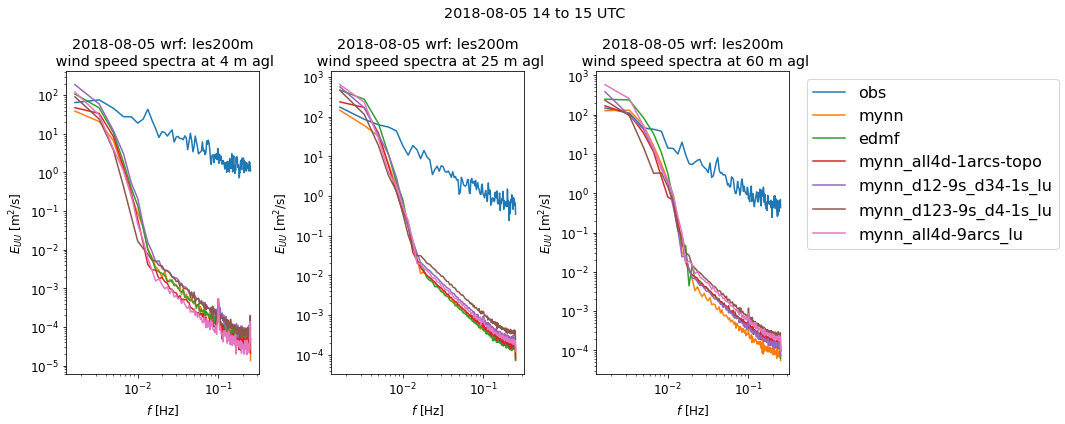

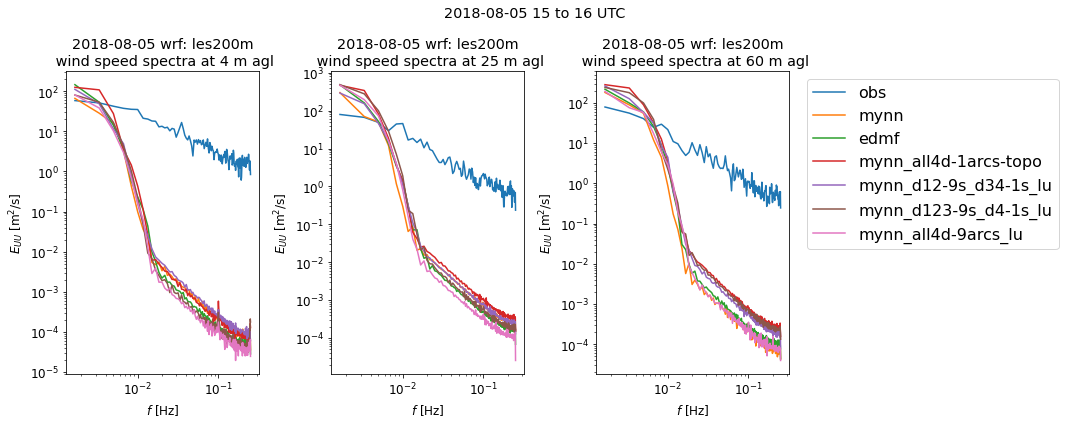

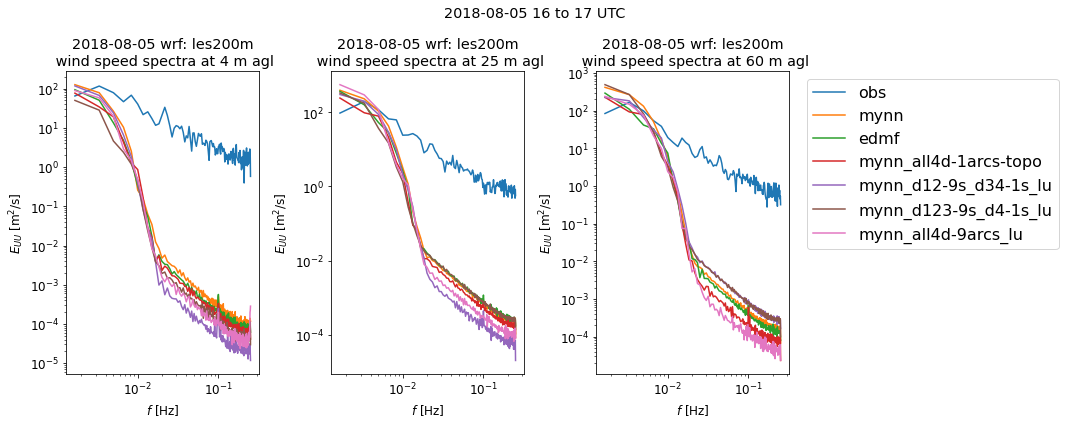

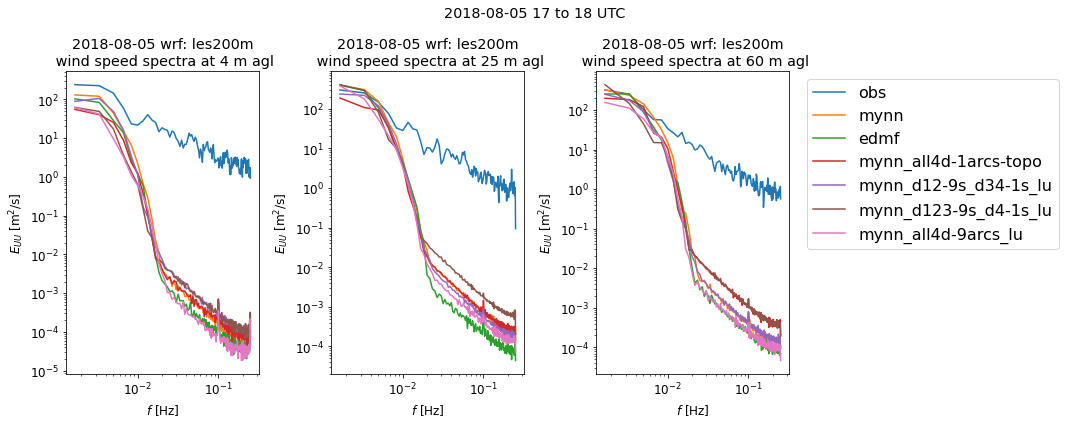

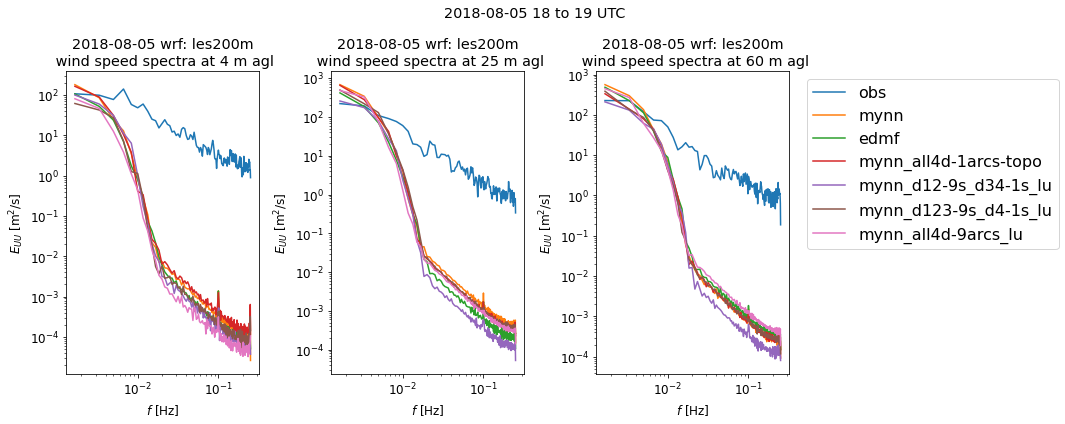

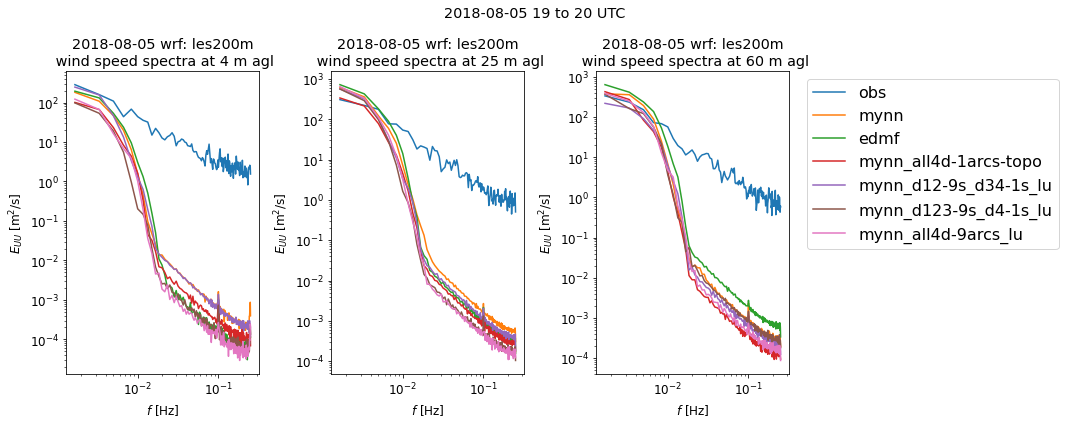

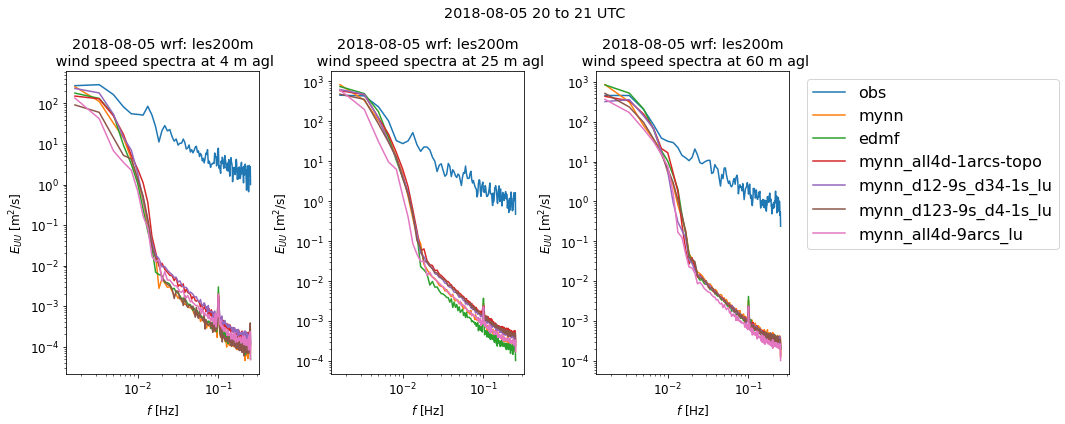

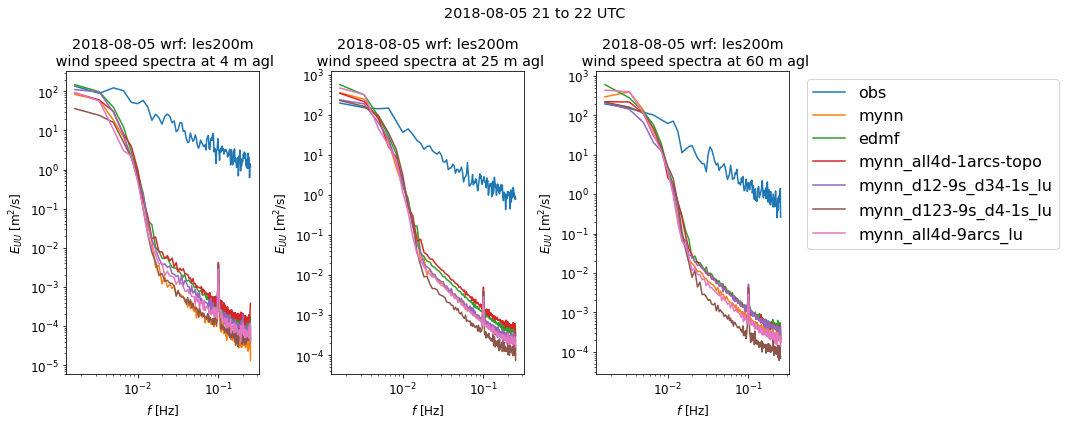

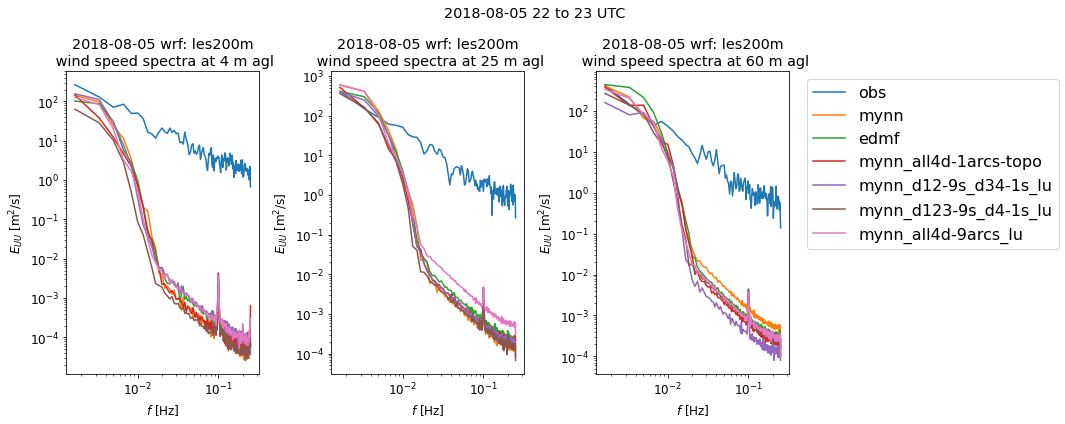

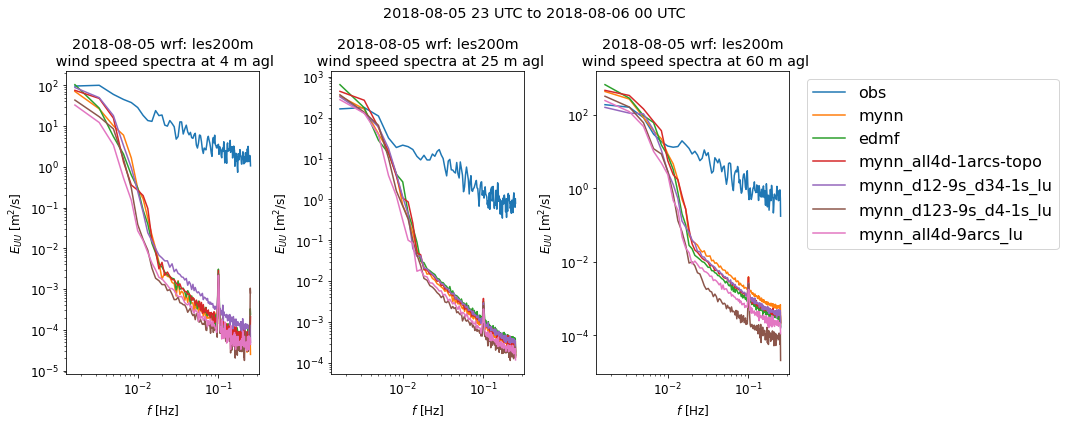

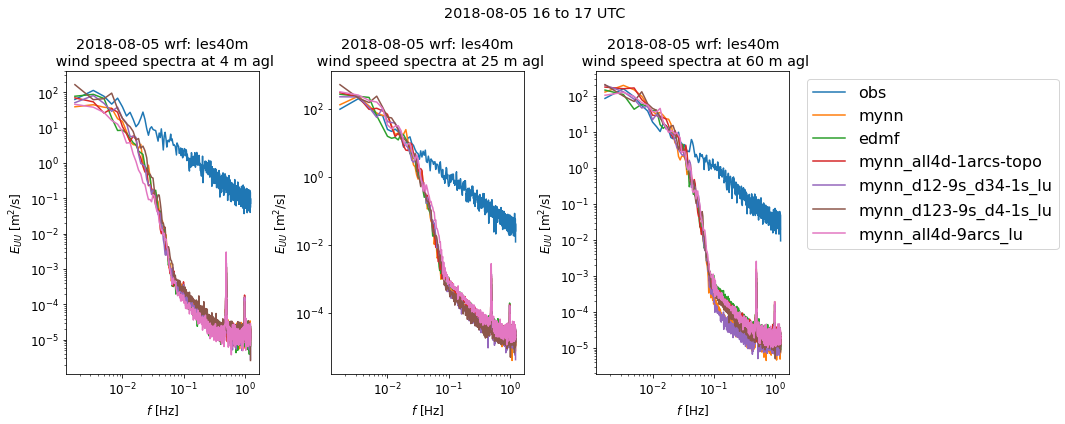

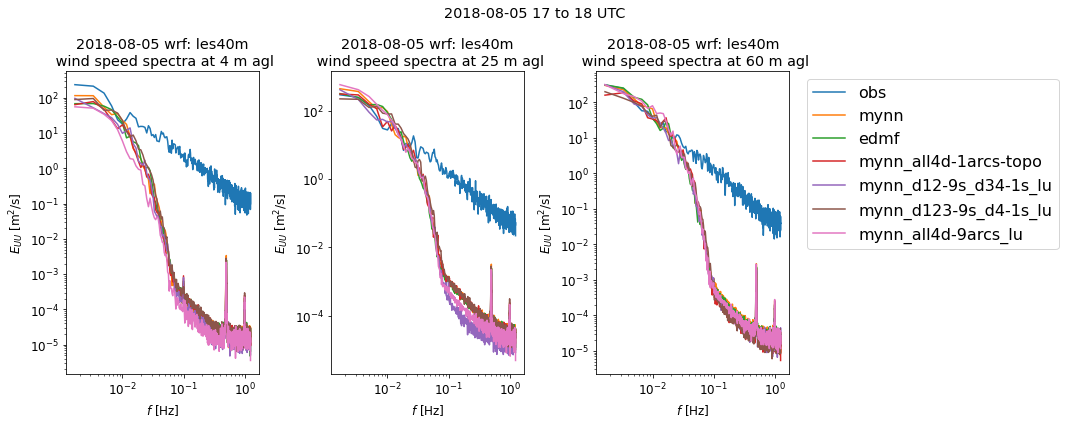

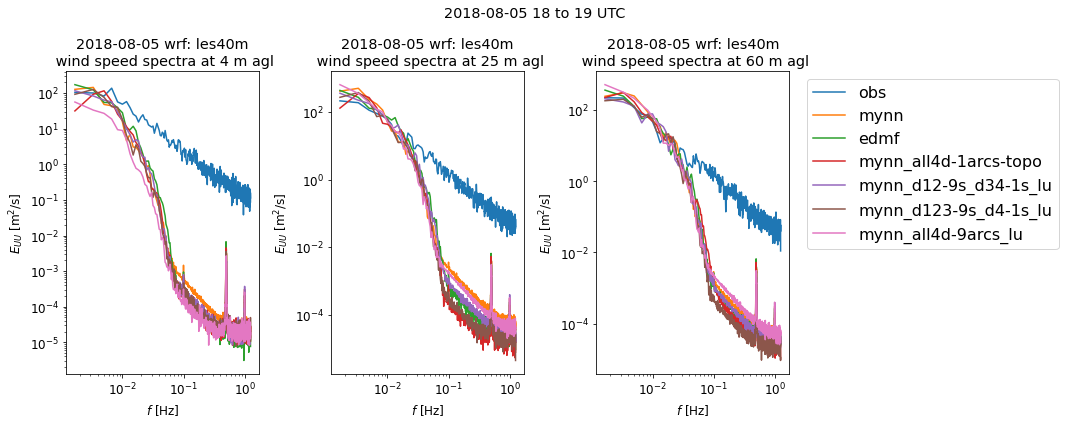

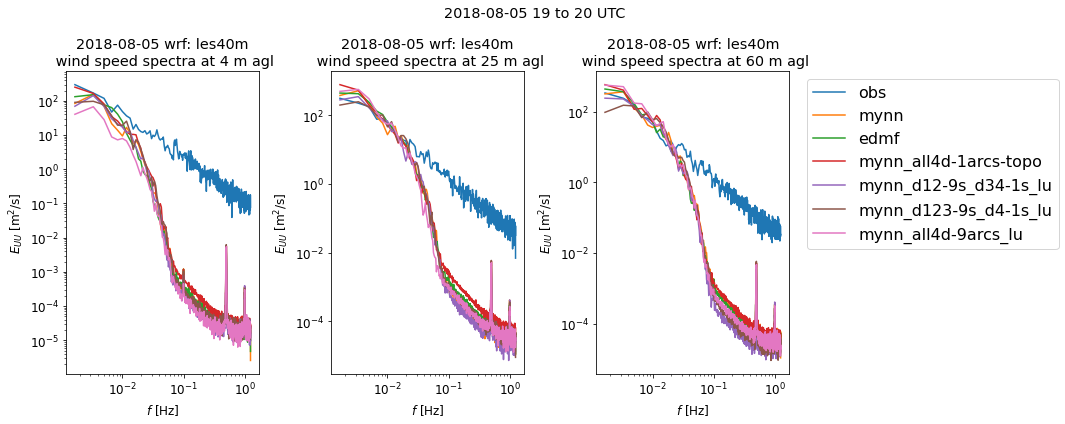

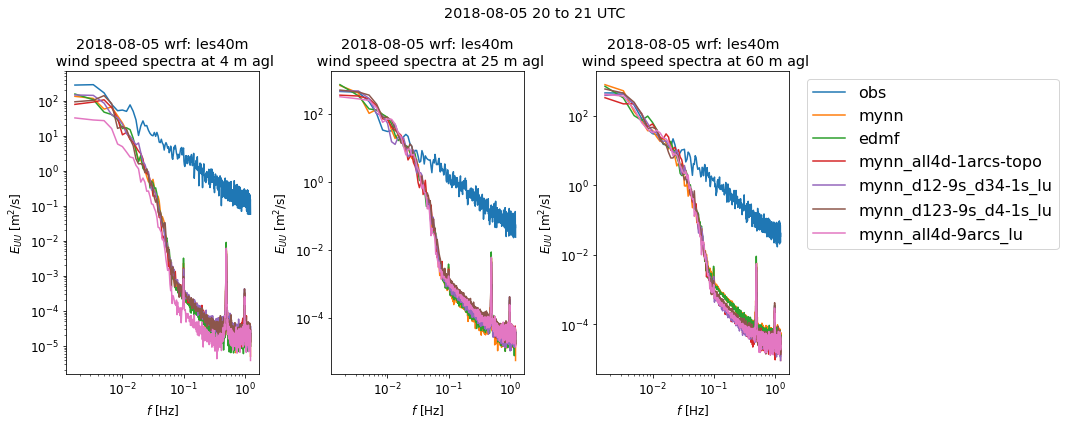

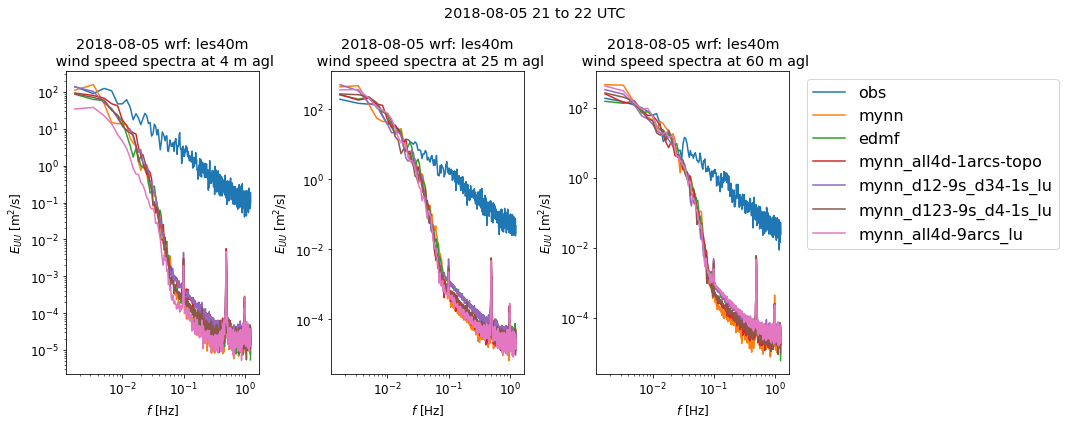

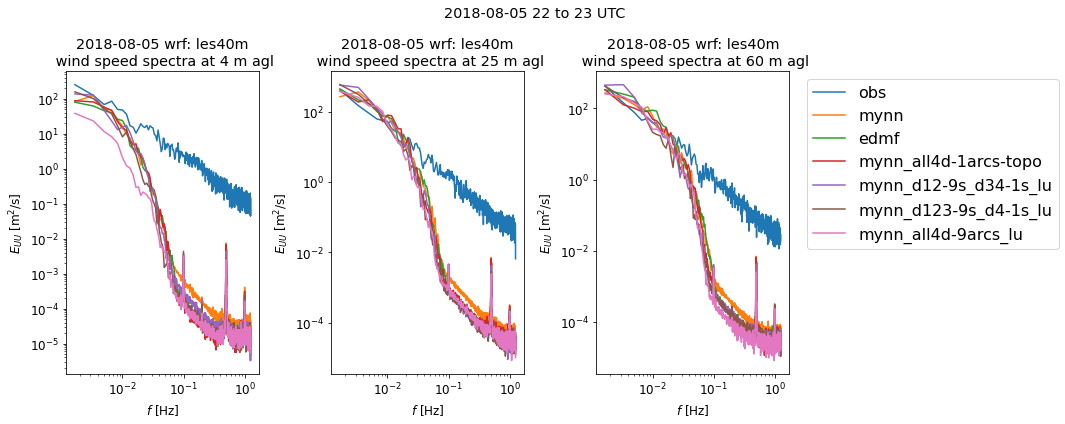

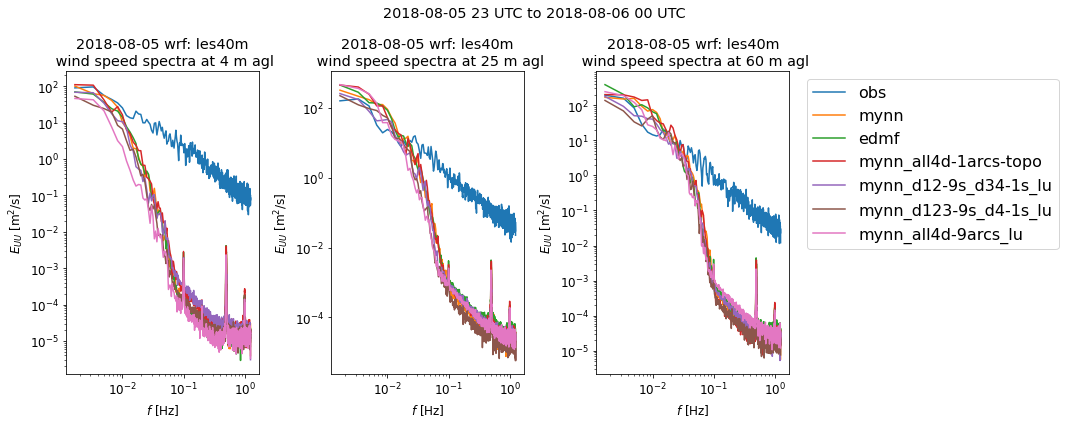

In [7]:
eval_date = '2018-08-05'
# sim = 'les200m'

for sim in sim_dict.keys(): 

    runs_dict = {}
    for run in runs_list:
        runs_dict[run] = read_1wrf_ts(eval_date, sim, run)
        
    obs4_ds = get_obs_ds(4, sim_dict[sim][1])
    obs25_ds = get_obs_ds(25, sim_dict[sim][1])
    obs60_ds = get_obs_ds(60, sim_dict[sim][1])

    for ind, val in enumerate(list(runs_dict.values())): 
        if ind == 0: 
            run_t_min = val['datetime'].min().values
            run_t_max = val['datetime'].max().values
        else: 
            if run_t_min > val['datetime'].min().values: 
                run_t_min = val['datetime'].min().values
            if run_t_max < val['datetime'].max().values:
                run_t_max = val['datetime'].max().values

    time_start = np.max([run_t_min, obs4_ds['time'].min().values]) + sim_dict[sim][2]
    time_end = np.min([run_t_max, obs4_ds['time'].max().values])

    obs4_ds = obs4_ds.sel(time=slice(time_start, time_end))
    obs25_ds = obs25_ds.sel(time=slice(time_start, time_end))
    obs60_ds = obs60_ds.sel(time=slice(time_start, time_end))

    for run in runs_list: 
        runs_dict[run] = runs_dict[run].sel(datetime=slice(time_start, time_end))

    t_list = pd.date_range(start=time_start, end=time_end, freq=spectra_avg_freq)
    
    for t in t_list: 

        obs4_spectra = get_obs_spectra(obs4_ds, t, t+spectra_avg_time, spectra_window)
        obs25_spectra = get_obs_spectra(obs25_ds, t, t+spectra_avg_time, spectra_window)
        obs60_spectra = get_obs_spectra(obs60_ds, t, t+spectra_avg_time, spectra_window)

        run_spectra_dict = {}
        for run in runs_list:
            run_spectra_dict[run] = get_wrf_spectra(runs_dict[run], t, t+spectra_avg_time, 
                                                    spectra_window)

        plot_4mspectra_dict = {'obs': obs4_spectra.to_dataframe()}
        for run in runs_list:
            plot_4mspectra_dict[run] = run_spectra_dict[run].sel(height=4).to_dataframe()

        plot_25mspectra_dict = {'obs': obs25_spectra.to_dataframe()}
        for run in runs_list:
            plot_25mspectra_dict[run] = run_spectra_dict[run].sel(height=25).to_dataframe()

        plot_60mspectra_dict = {'obs': obs60_spectra.to_dataframe()}
        for run in runs_list:
            plot_60mspectra_dict[run] = run_spectra_dict[run].sel(height=60).to_dataframe()

        fig, axs = plt.subplots(1, 3, figsize=(15, 6))

        plt.rcParams.update({'font.size': 12})

        _, ax = plot_spectrum(
                datasets=plot_4mspectra_dict,
                fields='wspd',
                showlegend=False, fig=fig, ax=axs[0])

        ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

        _, ax = plot_spectrum(
                datasets=plot_25mspectra_dict,
                fields='wspd',
                showlegend=False, fig=fig, ax=axs[1])

        ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 25 m agl')

        _, ax = plot_spectrum(
                datasets=plot_60mspectra_dict,
                fields='wspd',
                showlegend=True, fig=fig, ax=axs[2])

        ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 60 m agl')

        if t.day == (t+spectra_avg_time).day: 
            plt.suptitle(eval_date+' '+str(t.hour)+' to '+str((t+spectra_avg_time).hour)+' UTC')
        else: 
            plt.suptitle(t.strftime('%Y-%m-%d %H')+' UTC to '+(t+spectra_avg_time).strftime('%Y-%m-%d %H')+' UTC')

        plt.tight_layout()

        plt.savefig('plots_03d/'+sim+'_'+eval_date+'-'+str(t.hour)+'z_'
                    +spectra_window+'-'+spectra_avg_freq+'_3spectra.pdf')

        plt.show()

In [8]:
data_dir_df

2018-08-05     2018-09-01
mynn                           l1_0805m       l3_0901m
edmf                           l2_0805e       l4_0901e
mynn_all4d-1arcs-topo          l5_0805m            NaN
mynn_d12-9s_d34-1s_lu  n1_d12-9s_d34-1s            NaN
mynn_d123-9s_d4-1s_lu  n2_d123-9s_d4-1s            NaN
mynn_all4d-9arcs_lu               n3_9s            NaN
wrf_start                  8/4/18 12:00  8/31/18 12:00

In [76]:
obs4_ds = get_obs_ds(4, sim_dict[sim][1])
obs25_ds = get_obs_ds(25, sim_dict[sim][1])
obs60_ds = get_obs_ds(60, sim_dict[sim][1])
    
for ind, val in enumerate(list(runs_dict.values())): 
    if ind == 0: 
        run_t_min = val['datetime'].min().values
        run_t_max = val['datetime'].max().values
    else: 
        if run_t_min > val['datetime'].min().values: 
            run_t_min = val['datetime'].min().values
        if run_t_max < val['datetime'].max().values:
            run_t_max = val['datetime'].max().values

time_start = np.max([run_t_min, obs4_ds['time'].min().values]) + sim_dict[sim][2]
time_end = np.min([run_t_max, obs4_ds['time'].max().values])

obs4_ds = obs4_ds.sel(time=slice(time_start, time_end))
obs25_ds = obs25_ds.sel(time=slice(time_start, time_end))
obs60_ds = obs60_ds.sel(time=slice(time_start, time_end))

for run in runs_list: 
    runs_dict[run] = runs_dict[run].sel(datetime=slice(time_start, time_end))

t_list = pd.date_range(start=time_start, end=time_end, freq=spectra_avg_freq)

In [95]:
t_list[0].strftime('%Y-%m-%d %H')

'2018-08-05 16'

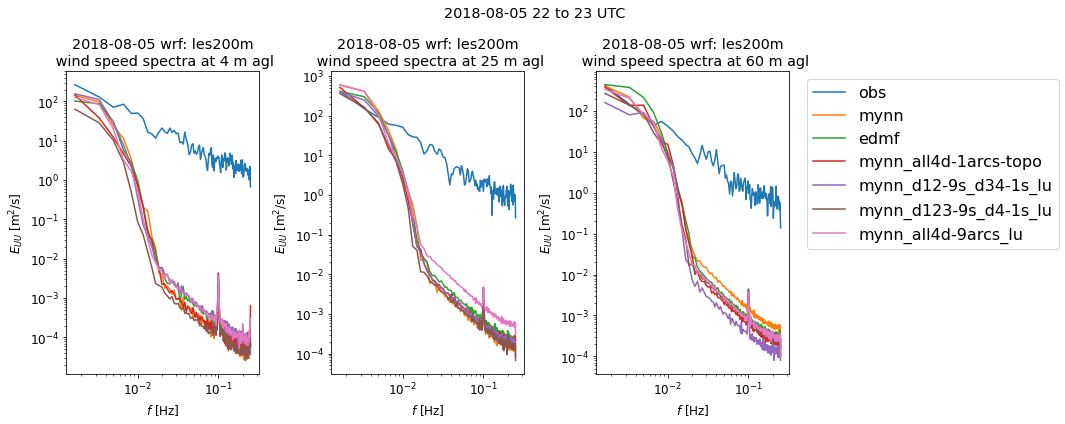

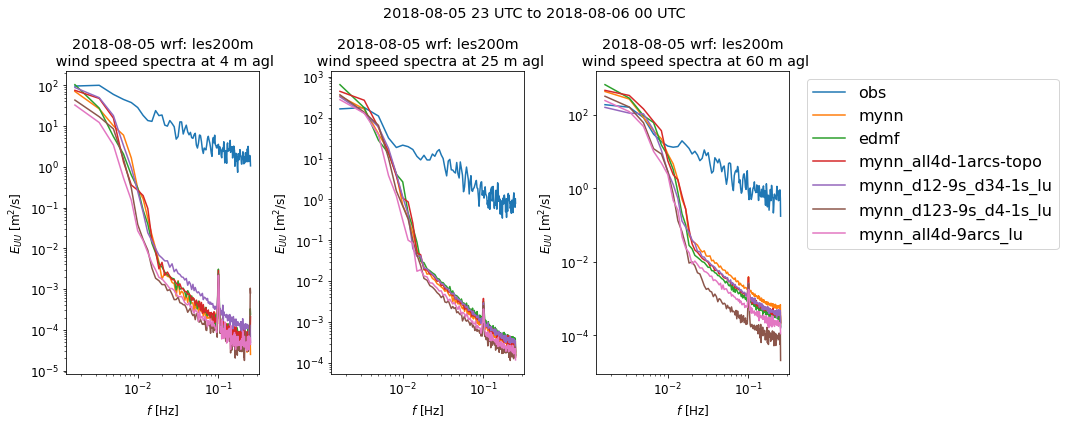

In [98]:
for t in t_list[-2:]: 

    obs4_spectra = get_obs_spectra(obs4_ds, t, t+spectra_avg_time, spectra_window)
    obs25_spectra = get_obs_spectra(obs25_ds, t, t+spectra_avg_time, spectra_window)
    obs60_spectra = get_obs_spectra(obs60_ds, t, t+spectra_avg_time, spectra_window)

    run_spectra_dict = {}
    for run in runs_list:
        run_spectra_dict[run] = get_wrf_spectra(runs_dict[run], t, t+spectra_avg_time, 
                                                spectra_window)

    plot_4mspectra_dict = {'obs': obs4_spectra.to_dataframe()}
    for run in runs_list:
        plot_4mspectra_dict[run] = run_spectra_dict[run].sel(height=4).to_dataframe()

    plot_25mspectra_dict = {'obs': obs25_spectra.to_dataframe()}
    for run in runs_list:
        plot_25mspectra_dict[run] = run_spectra_dict[run].sel(height=25).to_dataframe()

    plot_60mspectra_dict = {'obs': obs60_spectra.to_dataframe()}
    for run in runs_list:
        plot_60mspectra_dict[run] = run_spectra_dict[run].sel(height=60).to_dataframe()

    fig, axs = plt.subplots(1, 3, figsize=(15, 6))

    plt.rcParams.update({'font.size': 12})

    _, ax = plot_spectrum(
            datasets=plot_4mspectra_dict,
            fields='wspd',
            showlegend=False, fig=fig, ax=axs[0])

    ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

    _, ax = plot_spectrum(
            datasets=plot_25mspectra_dict,
            fields='wspd',
            showlegend=False, fig=fig, ax=axs[1])

    ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 25 m agl')

    _, ax = plot_spectrum(
            datasets=plot_60mspectra_dict,
            fields='wspd',
            showlegend=True, fig=fig, ax=axs[2])

    ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 60 m agl')
    
    if t.day == (t+spectra_avg_time).day: 
        plt.suptitle(eval_date+' '+str(t.hour)+' to '+str((t+spectra_avg_time).hour)+' UTC')
    else: 
        plt.suptitle(t.strftime('%Y-%m-%d %H')+' UTC to '+(t+spectra_avg_time).strftime('%Y-%m-%d %H')+' UTC')

    plt.tight_layout()

    plt.savefig('plots_03d/'+eval_date+'_'+sim+'_'+spectra_window+'-'+spectra_avg_freq+'_3spectra.pdf')

    plt.show()

In [ ]:
obs4_spectra = get_obs_spectra(obs4_ds, None, None, spectra_window)
obs25_spectra = get_obs_spectra(obs25_ds, None, None, spectra_window)
obs60_spectra = get_obs_spectra(obs60_ds, None, None, spectra_window)

run_spectra_dict = {}
for run in runs_list:
    run_spectra_dict[run] = get_wrf_spectra(runs_dict[run], None, None, spectra_window)

plot_4mspectra_dict = {'obs': obs4_spectra.to_dataframe()}
for run in runs_list:
    plot_4mspectra_dict[run] = run_spectra_dict[run].sel(height=4).to_dataframe()
    
plot_25mspectra_dict = {'obs': obs25_spectra.to_dataframe()}
for run in runs_list:
    plot_25mspectra_dict[run] = run_spectra_dict[run].sel(height=25).to_dataframe()
    
plot_60mspectra_dict = {'obs': obs60_spectra.to_dataframe()}
for run in runs_list:
    plot_60mspectra_dict[run] = run_spectra_dict[run].sel(height=60).to_dataframe()
    
    

In [9]:
eval_date

'2018-08-05'

In [12]:
np.arange(18, 24)

array([18, 19, 20, 21, 22, 23])

In [ ]:
np.arange(19, 24)

In [15]:
obs4_ds.sel(time=slice('2018-08-05T18', '2018-08-06T00'))

<xarray.Dataset>
Dimensions:            (time: 2160)
Coordinates:
  * time               (time) datetime64[ns] 2018-08-05T18:00:00 ... 2018-08-...
Data variables:
    base_time          datetime64[ns] ...
    time_offset        (time) datetime64[ns] dask.array<chunksize=(2160,), meta=np.ndarray>
    u_wind             (time) float32 dask.array<chunksize=(2160,), meta=np.ndarray>
    v_wind             (time) float32 dask.array<chunksize=(2160,), meta=np.ndarray>
    w_wind             (time) float32 dask.array<chunksize=(2160,), meta=np.ndarray>
    sonic_temperature  (time) float32 dask.array<chunksize=(2160,), meta=np.ndarray>
    lat                float32 ...
    lon                float32 ...
    alt                float32 ...
    wspd               (time) float32 dask.array<chunksize=(2160,), meta=np.ndarray>
    wdir               (time) float32 dask.array<chunksize=(2160,), meta=np.ndarray>
Attributes:
    command_line:          co2flx_ingest -n co2flx4m -s sgp -f C1
    Conventions:           ARM-1.2
    process_version:       ingest-co2flx-1.0-0.el6
    dod_version:           co2flxwind4m-a1-1.0
    input_source:          /data/collection/sgp/sgpco2flx4mC1.00/ARM-SGP-4m-2...
    site_id:               sgp
    platform_id:           co2flxwind4m
    facility_id:           C1
    data_level:            a1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    sensor_height:         4.7 m AGL
    datastream:            sgpco2flxwind4mC1.a1
    doi:                   10.5439/1258457
    history:               created by user dsmgr on machine ruby at 2018-08-0...

In [28]:
obs4_ds = get_obs_ds(4, sim_dict[sim][1])
obs25_ds = get_obs_ds(25, sim_dict[sim][1])
obs60_ds = get_obs_ds(60, sim_dict[sim][1])

# if sim == 'meso': 
    
#     for run in runs_list: 
#         runs_dict[run] = runs_dict[run].sel(datetime=eval_date)

# else: 
    
for ind, val in enumerate(list(runs_dict.values())): 
    if ind == 0: 
        run_t_min = val['datetime'].min().values
        run_t_max = val['datetime'].max().values
    else: 
        if run_t_min > val['datetime'].min().values: 
            run_t_min = val['datetime'].min().values
        if run_t_max < val['datetime'].max().values:
            run_t_max = val['datetime'].max().values

time_start = np.max([run_t_min, obs4_ds['time'].min().values]) + sim_dict[sim][2]
time_end = np.min([run_t_max, obs4_ds['time'].max().values])

obs4_ds = obs4_ds.sel(time=slice(time_start, time_end))
obs25_ds = obs25_ds.sel(time=slice(time_start, time_end))
obs60_ds = obs60_ds.sel(time=slice(time_start, time_end))

for run in runs_list: 
    runs_dict[run] = runs_dict[run].sel(datetime=slice(time_start, time_end))

print(time_start, time_end)

2018-08-05T12:00:00.000000000 2018-08-05T23:59:50.000000000


In [19]:
sim_dict[sim][2]

IndexError: list index out of range

In [24]:
obs4_spectra = get_obs_spectra(obs4_ds, time_start, time_end, spectra_window)

In [26]:
obs25_spectra

<xarray.Dataset>
Dimensions:    (frequency: 31)
Coordinates:
  * frequency  (frequency) float64 0.0 0.001667 0.003333 ... 0.04833 0.05
Data variables:
    wspd       (frequency) float32 37.72 273.3 207.2 131.8 ... 16.73 14.13 8.183

In [7]:
obs4_spectra = get_obs_spectra(obs4_ds, None, None, spectra_window)
obs25_spectra = get_obs_spectra(obs25_ds, None, None, spectra_window)
obs60_spectra = get_obs_spectra(obs60_ds, None, None, spectra_window)

run_spectra_dict = {}
for run in runs_list:
    run_spectra_dict[run] = get_wrf_spectra(runs_dict[run], None, None, spectra_window)

plot_4mspectra_dict = {'obs': obs4_spectra.to_dataframe()}
for run in runs_list:
    plot_4mspectra_dict[run] = run_spectra_dict[run].sel(height=4).to_dataframe()
    
plot_25mspectra_dict = {'obs': obs25_spectra.to_dataframe()}
for run in runs_list:
    plot_25mspectra_dict[run] = run_spectra_dict[run].sel(height=25).to_dataframe()
    
plot_60mspectra_dict = {'obs': obs60_spectra.to_dataframe()}
for run in runs_list:
    plot_60mspectra_dict[run] = run_spectra_dict[run].sel(height=60).to_dataframe()

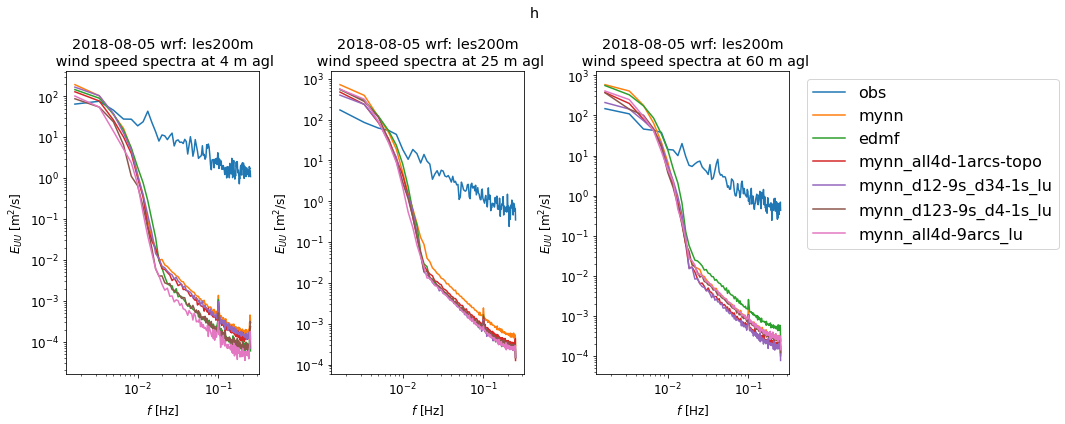

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

plt.rcParams.update({'font.size': 12})

_, ax = plot_spectrum(
        datasets=plot_4mspectra_dict,
        fields='wspd',
        showlegend=False, fig=fig, ax=axs[0])

ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

_, ax = plot_spectrum(
        datasets=plot_25mspectra_dict,
        fields='wspd',
        showlegend=False, fig=fig, ax=axs[1])

ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 25 m agl')

_, ax = plot_spectrum(
        datasets=plot_60mspectra_dict,
        fields='wspd',
        showlegend=True, fig=fig, ax=axs[2])

ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 60 m agl')

plt.suptitle('h')

plt.tight_layout()

#     plt.savefig('plots_03d/'+eval_date+'_'+sim+'_3spectra.pdf')

plt.show()

In [24]:
runs_dict = {}
for run in runs_list:
    runs_dict[run] = read_1wrf_ts(eval_date, sim, run)

In [27]:
data_dir_df

2018-08-05     2018-09-01
mynn                        l1_0805m       l3_0901m
edmf                        l2_0805e       l4_0901e
mynn_all4-1arcs             l5_0805m            NaN
mynn_d12-9s_d34-1s  n1_d12-9s_d34-1s            NaN
mynn_d123-9s_d4-1s  n2_d123-9s_d4-1s            NaN
mynn_all4-9arcs                n3_9s            NaN
wrf_start               8/4/18 12:00  8/31/18 12:00

In [25]:
runs_dict

{'mynn': 'i',
 'edmf': 'i',
 'mynn_all4-1arcs': 'i',
 'mynn_d12-9s_d34-1s': 'i',
 'mynn_d123-9s_d4-1s': 'i',
 'mynn_all4-9arcs': 'i'}

In [28]:
eval_date = '2018-08-05'
sim = 'meso'

# mynn_ds, edmf_ds = read_wrf_ts(eval_date, sim)

runs_dict = {}
for run in runs_list:
    runs_dict[run] = read_1wrf_ts(eval_date, sim, run)

# read_1wrf_ts(eval_date, sim, runs_list[0])

In [51]:
for ind, val in enumerate(list(runs_dict.values())): 
    if ind == 0: 
        run_t_min = val['datetime'].min().values
        run_t_max = val['datetime'].max().values
    else: 
        if run_t_min > val['datetime'].min().values: 
            run_t_min = val['datetime'].min().values
        if run_t_max < val['datetime'].max().values:
            run_t_max = val['datetime'].max().values

In [55]:
runs_dict['mynn']

<xarray.Dataset>
Dimensions:      (datetime: 12960, height: 3, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-04T12:00:10 ... 2018-08-06
  * height       (height) int64 4 25 60
  * station      (station) <U4 'z.c1'
Data variables:
    theta        (datetime, height, station) float64 299.7 299.8 ... 312.3 312.3
    pr           (datetime, height, station) float64 9.788e+04 ... 9.695e+04
    w            (datetime, height, station) float64 -0.01089 ... -0.04261
    u            (datetime, height, station) float64 -0.8431 -0.9107 ... -0.6466
    qv           (datetime, height, station) float64 0.0101 0.01004 ... 0.01062
    v            (datetime, height, station) float64 5.54 6.123 ... 8.271 9.402
    i            (station) int64 122
    j            (station) int64 126
    lat          (station) float64 36.62
    lon          (station) float64 -97.49
    zsurface     (station) float64 306.8
    t2           (datetime, station) float64 298.0 297.9 297.9 ... 310.3 310.2
    q2           (datetime, station) float64 0.01009 0.0101 ... 0.01089 0.01089
    u10          (datetime, station) float64 -0.909 -0.9003 ... -0.5749 -0.5695
    v10          (datetime, station) float64 6.022 5.879 5.69 ... 6.494 6.49
    psfc         (datetime, station) float64 9.791e+04 9.791e+04 ... 9.757e+04
    glw          (datetime, station) float64 376.0 376.0 376.0 ... 425.9 425.9
    gsw          (datetime, station) float64 21.27 21.27 21.27 ... 194.3 194.3
    hfx          (datetime, station) float64 -28.8 -33.22 -32.78 ... 7.213 7.407
    lh           (datetime, station) float64 16.39 16.18 16.12 ... 79.04 79.04
    tsk          (datetime, station) float64 297.5 297.3 297.3 ... 310.4 310.4
    slttop       (datetime, station) float64 301.3 301.3 301.3 ... 308.8 308.8
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.0 0.0 0.0 ... 0.03719 0.03719
    clw          (datetime, station) float64 0.00028 0.00122 0.00158 ... 0.0 0.0
    cldfrac2d    (datetime, station) float64 0.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 37.1 37.1 37.1 ... 33.41 33.4 33.4
    lwp          (datetime, station) float64 0.00028 0.0012 0.00156 ... 0.0 0.0
    iwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_sum       (datetime, station) float64 0.00028 0.0012 0.00156 ... 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.00028 0.0012 ... 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.0 0.00028 0.0012 ... 0.0 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qs        (datetime, station) float64 0.0 0.0 0.0 ... 4e-05 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.1403 0.4654 0.5659 ... 0.0 0.0
    tau_qi       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qs       (datetime, station) float64 0.0 0.0 0.0 ... 9e-05 9e-05 9e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.09879 0.429 ... 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.3451 0.3451 ... 0.609 0.609
    sza          (datetime, station) float64 86.8 

In [56]:
obs4_ds = get_obs_ds(4, sim_dict[sim][1])
obs25_ds = get_obs_ds(25, sim_dict[sim][1])
obs60_ds = get_obs_ds(60, sim_dict[sim][1])

if sim == 'meso': 
    
    for run in runs_list: 
        runs_dict[run] = runs_dict[run].sel(datetime=eval_date)
#         edmf_ds = edmf_ds.sel(datetime=eval_date)

else: 
    
    for ind, val in enumerate(list(runs_dict.values())): 
        if ind == 0: 
            run_t_min = val['datetime'].min().values
            run_t_max = val['datetime'].max().values
        else: 
            if run_t_min > val['datetime'].min().values: 
                run_t_min = val['datetime'].min().values
            if run_t_max < val['datetime'].max().values:
                run_t_max = val['datetime'].max().values

    time_start = np.max([run_t_min, obs4_ds['time'].min().values]) + sim_dict[sim][2]
    time_end = np.min([run_t_max, obs4_ds['time'].max().values])

    obs4_ds = obs4_ds.sel(time=slice(time_start, time_end))
    obs25_ds = obs25_ds.sel(time=slice(time_start, time_end))
    obs60_ds = obs60_ds.sel(time=slice(time_start, time_end))
    
    for run in runs_list: 
        runs_dict[run] = runs_dict[run].sel(datetime=slice(time_start, time_end))
    
#     mynn_ds = mynn_ds.sel(datetime=slice(time_start, time_end))
#     edmf_ds = edmf_ds.sel(datetime=slice(time_start, time_end))

    print(time_start, time_end)

In [58]:
spectra_window = '10min'

obs4_spectra = get_obs_spectra(obs4_ds, None, None, spectra_window)
obs25_spectra = get_obs_spectra(obs25_ds, None, None, spectra_window)
obs60_spectra = get_obs_spectra(obs60_ds, None, None, spectra_window)

run_spectra_dict = {}
for run in runs_list:
    run_spectra_dict[run] = get_wrf_spectra(runs_dict[run], None, None, spectra_window)

# mynn_spectra = get_wrf_spectra(mynn_ds, None, None, spectra_window)
# edmf_spectra = get_wrf_spectra(edmf_ds, None, None, spectra_window)

In [59]:
run_spectra_dict

{'mynn': <xarray.Dataset>
 Dimensions:    (frequency: 31, height: 3)
 Coordinates:
   * height     (height) int64 4 25 60
   * frequency  (frequency) float64 0.0 0.001667 0.003333 ... 0.04833 0.05
 Data variables:
     wspd       (height, frequency) float64 0.001214 0.1022 ... 1.746e-05,
 'edmf': <xarray.Dataset>
 Dimensions:    (frequency: 31, height: 3)
 Coordinates:
   * height     (height) int64 4 25 60
   * frequency  (frequency) float64 0.0 0.001667 0.003333 ... 0.04833 0.05
 Data variables:
     wspd       (height, frequency) float64 0.0007855 0.06456 ... 1.63e-05,
 'mynn_all4-1arcs': <xarray.Dataset>
 Dimensions:    (frequency: 31, height: 3)
 Coordinates:
   * height     (height) int64 4 25 60
   * frequency  (frequency) float64 0.0 0.001667 0.003333 ... 0.04833 0.05
 Data variables:
     wspd       (height, frequency) float64 0.001233 0.1189 ... 1.845e-05,
 'mynn_d12-9s_d34-1s': <xarray.Dataset>
 Dimensions:    (frequency: 31, height: 3)
 Coordinates:
   * height     (height)

In [63]:
spectra_window = '10min'

obs4_spectra = get_obs_spectra(obs4_ds, None, None, spectra_window)
obs25_spectra = get_obs_spectra(obs25_ds, None, None, spectra_window)
obs60_spectra = get_obs_spectra(obs60_ds, None, None, spectra_window)

run_spectra_dict = {}
for run in runs_list:
    run_spectra_dict[run] = get_wrf_spectra(runs_dict[run], None, None, spectra_window)

plot_4mspectra_dict = {'obs': obs4_spectra.to_dataframe()}
for run in runs_list:
    plot_4mspectra_dict[run] = run_spectra_dict[run].sel(height=4).to_dataframe()
    
plot_25mspectra_dict = {'obs': obs25_spectra.to_dataframe()}
for run in runs_list:
    plot_25mspectra_dict[run] = run_spectra_dict[run].sel(height=25).to_dataframe()
    
plot_60mspectra_dict = {'obs': obs60_spectra.to_dataframe()}
for run in runs_list:
    plot_60mspectra_dict[run] = run_spectra_dict[run].sel(height=60).to_dataframe()

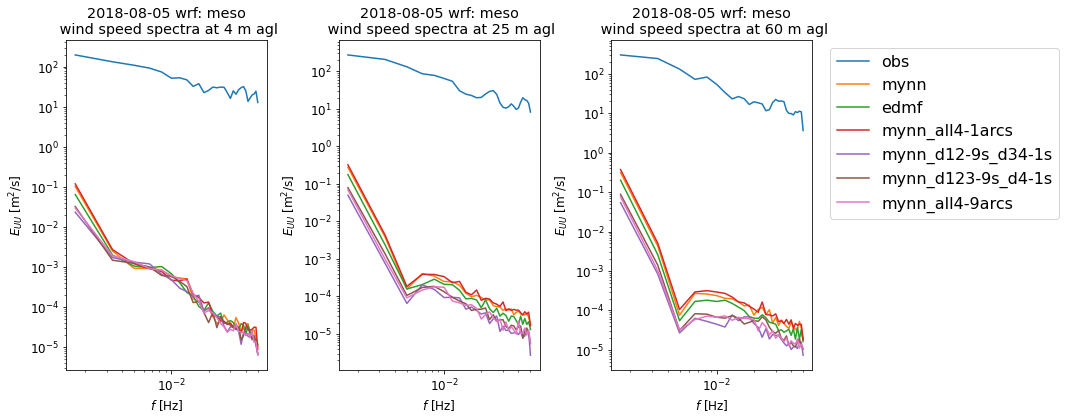

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

plt.rcParams.update({'font.size': 12})

_, ax = plot_spectrum(
        datasets=plot_4mspectra_dict,
        fields='wspd',
        showlegend=False, fig=fig, ax=axs[0])

ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

_, ax = plot_spectrum(
        datasets=plot_25mspectra_dict,
        fields='wspd',
        showlegend=False, fig=fig, ax=axs[1])

ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 25 m agl')

_, ax = plot_spectrum(
        datasets=plot_60mspectra_dict,
        fields='wspd',
        showlegend=True, fig=fig, ax=axs[2])

ax.set_title(eval_date+' wrf: '+sim+'\n wind speed spectra at 60 m agl')

plt.tight_layout()

#     plt.savefig('plots_03d/'+eval_date+'_'+sim+'_3spectra.pdf')

plt.show()

In [5]:
edmf_ds

<xarray.Dataset>
Dimensions:      (datetime: 17999, height: 3, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-05T14:00:02 ... 2018-08-05...
  * height       (height) int64 4 25 60
  * station      (station) <U4 'z.c1'
Data variables:
    v            (datetime, height, station) float64 3.452 8.154 ... 7.119 10.46
    w            (datetime, height, station) float64 -0.01104 ... -0.07322
    pr           (datetime, height, station) float64 9.797e+04 ... 9.69e+04
    qv           (datetime, height, station) float64 0.01524 0.01506 ... 0.01057
    theta        (datetime, height, station) float64 302.8 302.0 ... 312.8 312.5
    u            (datetime, height, station) float64 -0.311 -0.4049 ... -1.662
    i            (station) int64 112
    j            (station) int64 211
    lat          (station) float64 36.61
    lon          (station) float64 -97.49
    zsurface     (station) float64 311.1
    t2           (datetime, station) float64 301.1 301.1 301.1 ... 310.7 310.8
    q2           (datetime, station) float64 0.01527 0.01527 ... 0.0111 0.0111
    u10          (datetime, station) float64 -0.3694 -0.3736 ... -0.457 -0.4525
    v10          (datetime, station) float64 4.807 4.825 4.845 ... 4.541 4.534
    psfc         (datetime, station) float64 9.798e+04 9.798e+04 ... 9.753e+04
    glw          (datetime, station) float64 388.0 388.0 388.0 ... 428.3 428.3
    gsw          (datetime, station) float64 318.1 318.1 318.1 ... 187.2 187.2
    hfx          (datetime, station) float64 133.0 133.1 133.2 ... 20.44 20.42
    lh           (datetime, station) float64 66.94 66.93 66.95 ... 65.79 65.78
    tsk          (datetime, station) float64 304.0 304.0 304.0 ... 311.3 311.3
    slttop       (datetime, station) float64 299.9 299.9 299.9 ... 311.0 311.0
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.03857 0.03857 ... 0.03857 0.03857
    clw          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cldfrac2d    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 35.07 35.06 35.06 ... 34.52 34.49
    lwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_sum       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qs        (datetime, station) float64 3e-05 3e-05 3e-05 ... 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qs       (datetime, station) float64 1e-05 1e-05 1e-05 ... 5e-05 5e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.672 0.672 0.672 ... 0.6064 0.6064
    sza          (datetime, sta

In [19]:
list(data_dir_df.index)[:-1]

['mynn',
 'edmf',
 'mynn_all4-1arcs',
 'mynn_d12-9s_d34-1s',
 'mynn_d123-9s_d4-1s',
 'mynn_all4-9arcs']

In [4]:
obs4_ds

<xarray.Dataset>
Dimensions:            (time: 19799)
Coordinates:
  * time               (time) datetime64[ns] 2018-08-05T13:00:02 ... 2018-08-...
Data variables:
    base_time          datetime64[ns] ...
    time_offset        (time) datetime64[ns] dask.array<chunksize=(19799,), meta=np.ndarray>
    u_wind             (time) float32 dask.array<chunksize=(19799,), meta=np.ndarray>
    v_wind             (time) float32 dask.array<chunksize=(19799,), meta=np.ndarray>
    w_wind             (time) float32 dask.array<chunksize=(19799,), meta=np.ndarray>
    sonic_temperature  (time) float32 dask.array<chunksize=(19799,), meta=np.ndarray>
    lat                float32 ...
    lon                float32 ...
    alt                float32 ...
    wspd               (time) float32 dask.array<chunksize=(19799,), meta=np.ndarray>
    wdir               (time) float32 dask.array<chunksize=(19799,), meta=np.ndarray>
Attributes:
    command_line:          co2flx_ingest -n co2flx4m -s sgp -f C1
    Conventions:           ARM-1.2
    process_version:       ingest-co2flx-1.0-0.el6
    dod_version:           co2flxwind4m-a1-1.0
    input_source:          /data/collection/sgp/sgpco2flx4mC1.00/ARM-SGP-4m-2...
    site_id:               sgp
    platform_id:           co2flxwind4m
    facility_id:           C1
    data_level:            a1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    sensor_height:         4.7 m AGL
    datastream:            sgpco2flxwind4mC1.a1
    doi:                   10.5439/1258457
    history:               created by user dsmgr on machine ruby at 2018-08-0...

In [20]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

def read_1wrf_ts(eval_date, sim, run):
    
    col = data_dir_df[eval_date]
    sim_val = sim_dict[sim]

    # # simulation start time
    wrf_start = col['wrf_start']
    
    wrf_file_path = wrf_runs_dir+col[run]+'/z_ts/z.'+sim_val[0]
    wrf_tower = Tower(wrf_file_path)

    wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, sim_val[1])
    wrf_ds['wspd'], wrf_ds['wdir'] = calc_wind(wrf_ds)
    
    return wrf_ds

def read_wrf_ts(eval_date, sim):
    
    col = data_dir_df[eval_date]
    sim_val = sim_dict[sim]

    # # simulation start time
    wrf_start = col['wrf_start']
    
    mynn_file_path = wrf_runs_dir+col['mynn']+'/z_ts/z.'+sim_val[0]
    mynn_tower = Tower(mynn_file_path)

    mynn_ds = read_tower_to_ds(mynn_tower, wrf_start, sim_val[1])
    mynn_ds['wspd'], mynn_ds['wdir'] = calc_wind(mynn_ds)
    
    edmf_file_path = wrf_runs_dir+col['edmf']+'/z_ts/z.'+sim_val[0]
    edmf_tower = Tower(edmf_file_path)

    edmf_ds = read_tower_to_ds(edmf_tower, wrf_start, sim_val[1])
    edmf_ds['wspd'], edmf_ds['wdir'] = calc_wind(edmf_ds)
   
    return mynn_ds, edmf_ds

def get_obs_ds(hgt, dt): 
    
    if hgt == 4:
        nc_tail = ''
    else:
        nc_tail = '.custom'
        
    obs_nc = obs_dir+'sgpco2flxwind'+str(hgt)+'mC1.a1/sgpco2flxwind'\
        +str(hgt)+'mC1.a1.'+eval_date.replace('-', '')+'.000000'+nc_tail+'.nc'
        
    obs_ds = xr.open_mfdataset(obs_nc)

    obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

    obs_ds = obs_ds.sel(time=eval_date)
    
    obs_ds = obs_ds.resample(time=str(dt)+'S').nearest()
    
    return obs_ds

def get_obs_spectra(obs_ds, time_start, time_end, spectra_window):
    
    obs_spectra = calc_spectra(obs_ds.sel(time=slice('2018-08-05T18', '2018-08-05T19')),
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                           window_length=spectra_window,
                          )
    
    return obs_spectra

def get_wrf_spectra(wrf_ds, time_start, time_end, spectra_window):
    
    wrf_spectra = calc_spectra(wrf_ds.sel(datetime=slice('2018-08-05T18', '2018-08-05T19')),
                              var_oi='wspd',
                              spectra_dim='datetime',
                              window='hamming',
                                level_dim='height',
                               window_length=spectra_window,
                              )
    
    return wrf_spectra

def plot_spectra(eval_date, sim): 

    mynn_ds, edmf_ds = read_wrf_ts(eval_date, sim)
    
    obs4_ds = get_obs_ds(4, sim_dict[sim][1])
    obs25_ds = get_obs_ds(25, sim_dict[sim][1])
    obs60_ds = get_obs_ds(60, sim_dict[sim][1])

    if sim == 'meso': 

#         obs_ds = obs_ds.sel(time=eval_date)
        mynn_ds = mynn_ds.sel(datetime=eval_date)
        edmf_ds = edmf_ds.sel(datetime=eval_date)

    else: 

        time_start = np.max([mynn_ds['datetime'].min().values, edmf_ds['datetime'].min().values, 
                             obs4_ds['time'].min().values]) + les_spinup
        time_end = np.min([mynn_ds['datetime'].max().values, edmf_ds['datetime'].max().values, 
                           obs4_ds['time'].max().values])

        obs4_ds = obs4_ds.sel(time=slice(time_start, time_end))
        obs25_ds = obs25_ds.sel(time=slice(time_start, time_end))
        obs60_ds = obs60_ds.sel(time=slice(time_start, time_end))
        mynn_ds = mynn_ds.sel(datetime=slice(time_start, time_end))
        edmf_ds = edmf_ds.sel(datetime=slice(time_start, time_end))
        
        print(time_start, time_end)
        
    spectra_window = '10min'
        
#     obs4_spectra = calc_spectra(obs4_ds.sel(time=slice('2018-08-05T18', '2018-08-05T19')),
#                           var_oi='wspd',
#                           spectra_dim='time',
#                           window='hamming',
#                            window_length=spectra_window,
#                           )

#     mynn_spectra = calc_spectra(mynn_ds.sel(datetime=slice('2018-08-05T18', '2018-08-05T19')),
#                               var_oi='wspd',
#                               spectra_dim='datetime',
#                               window='hamming',
#                                 level_dim='height',
#                                window_length=spectra_window,
#                               )
    
#     edmf_spectra = calc_spectra(edmf_ds.sel(datetime=slice('2018-08-05T18', '2018-08-05T19')),
#                               var_oi='wspd',
#                               spectra_dim='datetime',
#                               window='hamming',
#                                 level_dim='height',
#                                window_length=spectra_window,
#                               )
    
    obs4_spectra = get_obs_spectra(obs4_ds)
    obs25_spectra = get_obs_spectra(obs25_ds)
    obs60_spectra = get_obs_spectra(obs60_ds)
    mynn_spectra = get_wrf_spectra(mynn_ds)
    edmf_spectra = get_wrf_spectra(edmf_ds)

    fig, ax = plt.subplots(figsize=(12, 6))
    
    plt.rcParams.update({'font.size': 12})
    
    _, ax = plot_spectrum(
            datasets={'obs': obs4_spectra.to_dataframe(), 
                      'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                      'edmf': edmf_spectra.sel(height=4).to_dataframe()},
            fields='wspd',
            showlegend=True, fig=fig, ax=ax)

    plt.title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

#     plt.savefig('plots_03d/'+eval_date+'_'+sim+'_4m'+'_spectra.pdf')

    plt.show()

In [134]:
def get_obs_ds(hgt, dt): 
    
    if hgt == 4:
        nc_tail = ''
    else:
        nc_tail = '.custom'
        
    obs_nc = obs_dir+'sgpco2flxwind'+str(hgt)+'mC1.a1/sgpco2flxwind'\
        +str(hgt)+'mC1.a1.'+eval_date.replace('-', '')+'.000000'+nc_tail+'.nc'
        
    obs_ds = xr.open_mfdataset(obs_nc)

    obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

    obs_ds = obs_ds.sel(time=eval_date)
    
    obs_ds = obs_ds.resample(time=str(dt)+'S').nearest()
    
    return obs_ds

In [135]:
dt = d04_wrf_dt

obs4_ds = get_obs_ds(4, dt)
obs25_ds = get_obs_ds(25, dt)
obs60_ds = get_obs_ds(60, dt)

In [ ]:
obs_spectra = calc_spectra(obs_ds.sel(time=slice('2018-08-05T18', '2018-08-05T19')),
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                           window_length='10min',
                          )

mynn_spectra = calc_spectra(mynn_ds.sel(datetime=slice('2018-08-05T18', '2018-08-05T19')),
                          var_oi='wspd',
                          spectra_dim='datetime',
                          window='hamming',
                            level_dim='height',
                           window_length='10min',
                          )

ax = plot_spectrum(
            datasets={'obs': obs_spectra.to_dataframe(), 
                      'mynn': mynn_spectra.sel(height=25).to_dataframe()},
            fields='wspd',
            showlegend=True)

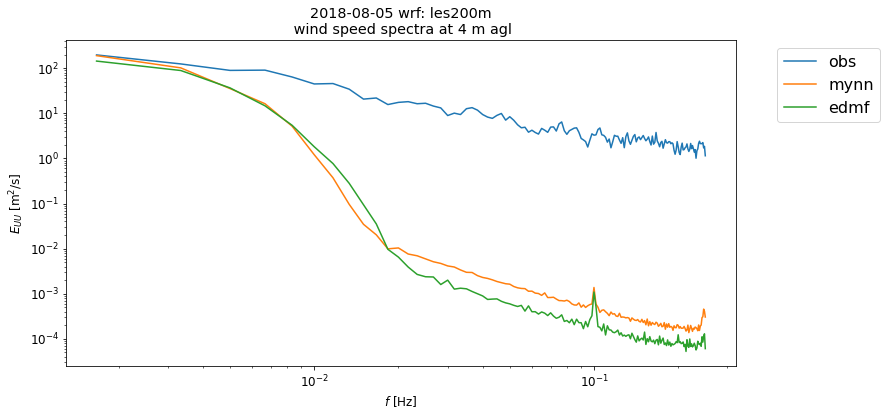

In [142]:
eval_date = '2018-08-05'

# for sim in sim_dict.keys(): 
plot_spectra(eval_date, 'les200m')

In [138]:
mynn_ds = mynn_ds.sel(datetime=eval_date)

In [91]:
obs_nc = obs_dir+'sgpco2flxwind4mC1.a1/sgpco2flxwind4mC1.a1.'+eval_date.replace('-', '')+'.000000.nc'
obs_ds = xr.open_mfdataset(obs_nc)

obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

obs_ds = obs_ds.sel(time=eval_date)

obs_ds = obs_ds.resample(time='0.4S').nearest()

In [115]:
obs_nc = obs_dir+'sgpco2flxwind25mC1.a1/sgpco2flxwind25mC1.a1.'+eval_date.replace('-', '')+'.000000.custom.nc'
obs_ds = xr.open_mfdataset(obs_nc)

obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

obs_ds = obs_ds.sel(time=eval_date)

obs_ds = obs_ds.resample(time='0.4S').nearest()

In [ ]:
mynn_ds = mynn_ds.sel(datetime=eval_date)
edmf_ds = edmf_ds.sel(datetime=eval_date)

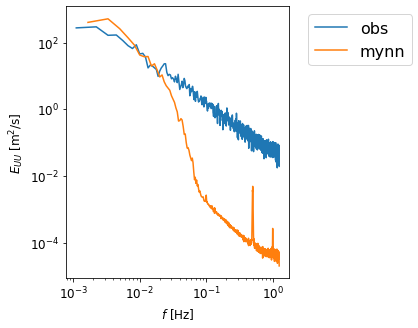

In [117]:
obs_spectra = calc_spectra(obs_ds.sel(time=slice('2018-08-05T18', '2018-08-05T19')),
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                           window_length='10min',
                          )

mynn_spectra = calc_spectra(mynn_ds.sel(datetime=slice('2018-08-05T18', '2018-08-05T19')),
                          var_oi='wspd',
                          spectra_dim='datetime',
                          window='hamming',
                            level_dim='height',
                           window_length='10min',
                          )

ax = plot_spectrum(
            datasets={'obs': obs_spectra.to_dataframe(), 
                      'mynn': mynn_spectra.sel(height=25).to_dataframe()},
            fields='wspd',
            showlegend=True)

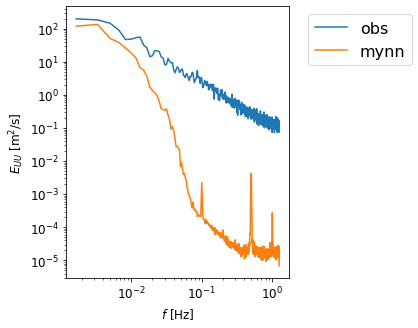

In [104]:
obs_spectra = calc_spectra(obs_ds.sel(time=slice('2018-08-05T20', '2018-08-05T21')),
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
#                            interval='120min',
                           window_length='10min',
#                            tstart=''
                          )

mynn_spectra = calc_spectra(mynn_ds.sel(datetime=slice('2018-08-05T20', '2018-08-05T21')),
                          var_oi='wspd',
                          spectra_dim='datetime',
                          window='hamming',
                            level_dim='height',
                           interval='120min',
                           window_length='10min',
                          )

ax = plot_spectrum(
            datasets={'obs': obs_spectra.to_dataframe(), 
                      'mynn': mynn_spectra.sel(height=4).to_dataframe()},
            fields='wspd',
            showlegend=True)

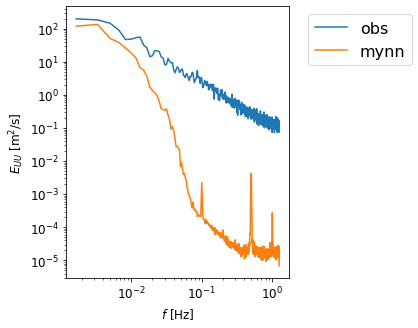

In [109]:
obs_spectra = calc_spectra(obs_ds.sel(time=slice('2018-08-05T20', '2018-08-05T21')),
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
#                            interval='30min',
                           window_length='10min',
#                            tstart=''
                          )

mynn_spectra = calc_spectra(mynn_ds.sel(datetime=slice('2018-08-05T20', '2018-08-05T21')),
                          var_oi='wspd',
                          spectra_dim='datetime',
                          window='hamming',
                            level_dim='height',
                           interval='120min',
                           window_length='10min',
                          )

ax = plot_spectrum(
            datasets={'obs': obs_spectra.to_dataframe(), 
                      'mynn': mynn_spectra.sel(height=4).to_dataframe()},
            fields='wspd',
            showlegend=True)

In [68]:
obs_spectra

<xarray.Dataset>
Dimensions:    (frequency: 46)
Coordinates:
  * frequency  (frequency) float64 0.0 0.001111 0.002222 ... 0.04889 0.05
Data variables:
    wspd       (frequency) float32 4.013 43.56 33.3 24.62 ... 8.378 8.899 4.467

In [23]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

def read_wrf_ts(eval_date, sim):
    
    col = data_dir_df[eval_date]
    sim_val = sim_dict[sim]

    # # simulation start time
    wrf_start = col['wrf_start']
    
    mynn_file_path = wrf_runs_dir+col['mynn']+'/z_ts/z.'+sim_val[0]
    mynn_tower = Tower(mynn_file_path)

    mynn_ds = read_tower_to_ds(mynn_tower, wrf_start, sim_val[1])
    mynn_ds['wspd'], mynn_ds['wdir'] = calc_wind(mynn_ds)
    
    edmf_file_path = wrf_runs_dir+col['edmf']+'/z_ts/z.'+sim_val[0]
    edmf_tower = Tower(edmf_file_path)

    edmf_ds = read_tower_to_ds(edmf_tower, wrf_start, sim_val[1])
    edmf_ds['wspd'], edmf_ds['wdir'] = calc_wind(edmf_ds)
   
    return mynn_ds, edmf_ds

def plot_spectra(eval_date, sim): 

    mynn_ds, edmf_ds = read_wrf_ts(eval_date, sim)

    obs_nc = obs_dir+'sgpco2flxwind4mC1.a1/sgpco2flxwind4mC1.a1.'+eval_date.replace('-', '')+'.000000.nc'
    obs_ds = xr.open_mfdataset(obs_nc)

    obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

    if sim == 'meso': 

        obs_ds = obs_ds.sel(time=eval_date)
        mynn_ds = mynn_ds.sel(datetime=eval_date)
        edmf_ds = edmf_ds.sel(datetime=eval_date)

    else: 

        time_start = np.max([mynn_ds['datetime'].min().values, edmf_ds['datetime'].min().values, 
                             obs_ds['time'].min().values]) + les_spinup
        time_end = np.min([mynn_ds['datetime'].max().values, edmf_ds['datetime'].max().values, 
                           obs_ds['time'].max().values])

    #     print(time_start, time_end)

        obs_ds = obs_ds.sel(time=slice(time_start, time_end))
        mynn_ds = mynn_ds.sel(datetime=slice(time_start, time_end))
        edmf_ds = edmf_ds.sel(datetime=slice(time_start, time_end))

    obs_spectra = calc_spectra(obs_ds,
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                          )

    mynn_spectra = calc_spectra(mynn_ds,
                          var_oi='wspd',
                          spectra_dim='datetime',
                          level_dim='height',
                          window='hamming')

    edmf_spectra = calc_spectra(edmf_ds,
                          var_oi='wspd',
                          spectra_dim='datetime',
                          level_dim='height',
                          window='hamming')

    fig, ax = plt.subplots(figsize=(12, 6))
    
    plt.rcParams.update({'font.size': 12})
    
    _, ax = plot_spectrum(
            datasets={'obs': obs_spectra.to_dataframe(), 
                      'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                      'edmf': edmf_spectra.sel(height=4).to_dataframe()},
            fields='wspd',
            showlegend=True, fig=fig, ax=ax)

    plt.title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

    plt.savefig('plots_03d/'+eval_date+'_'+sim+'_4m'+'_spectra.pdf')

    plt.show()

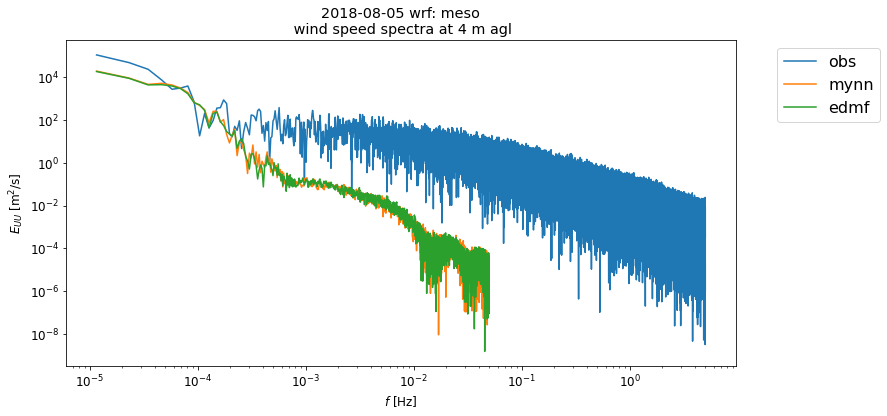

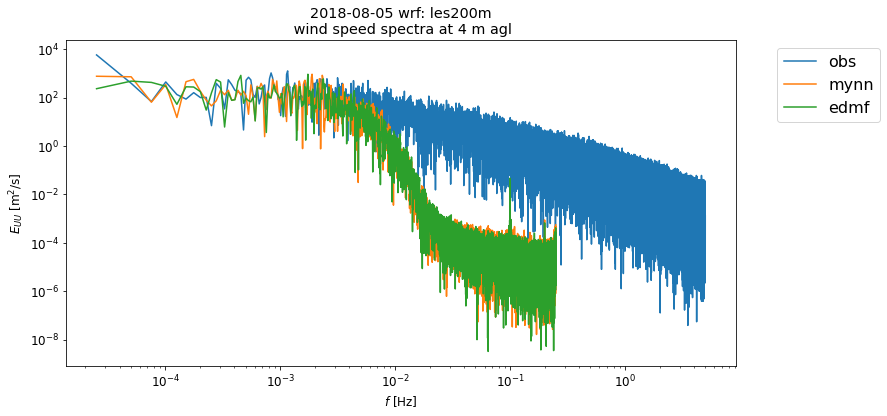

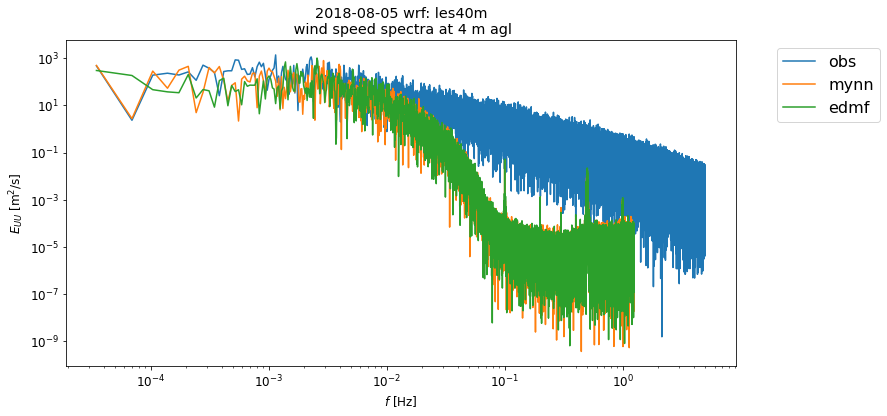

In [17]:
eval_date = '2018-08-05'

for sim in sim_dict.keys(): 
    plot_spectra(eval_date, sim)

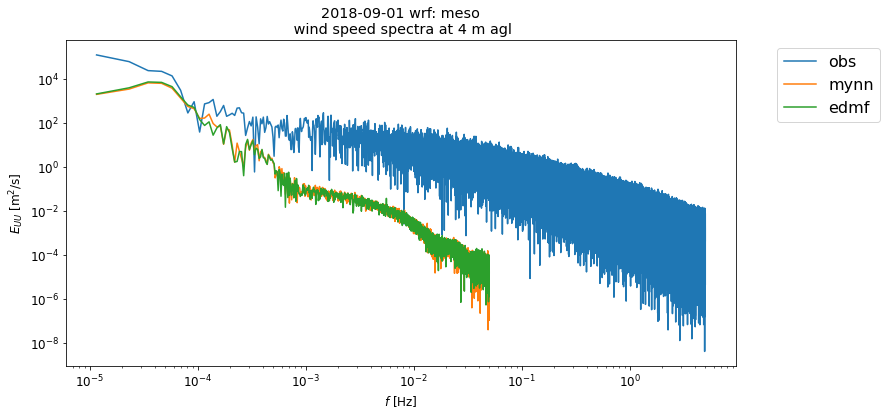

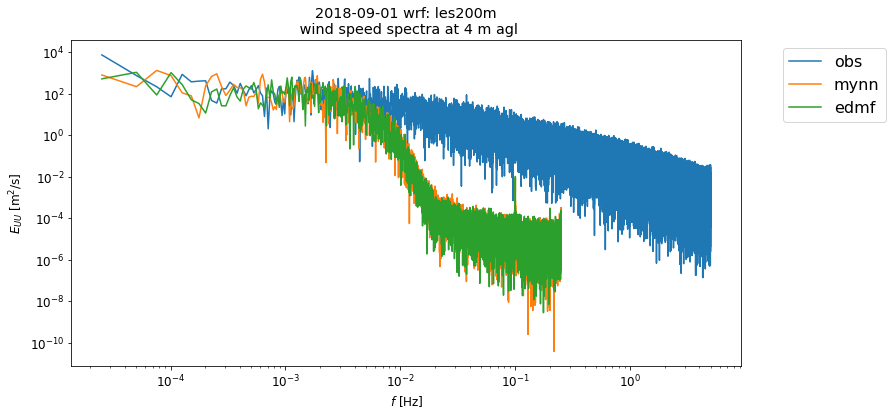

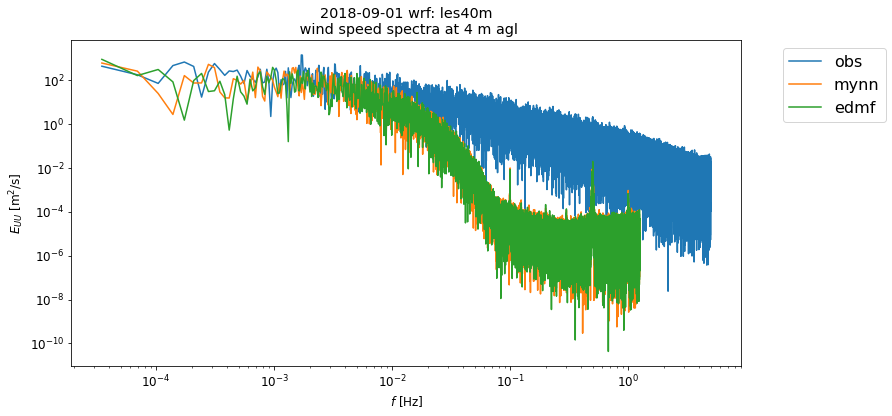

In [18]:
eval_date = '2018-09-01'

for sim in sim_dict.keys(): 
    plot_spectra(eval_date, sim)

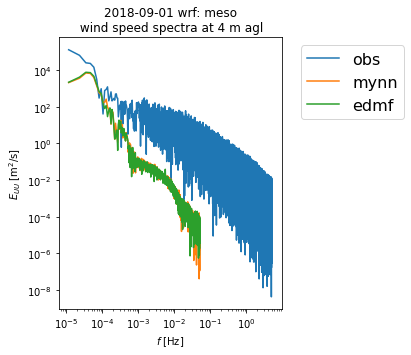

In [8]:
plot_spectra(eval_date, 'meso')

In [3]:
sim_dict.keys()

dict_keys(['meso', 'les200m', 'les40m'])

In [5]:
eval_date = '2018-09-01'
sim = 'meso'

# mynn_ds, edmf_ds = read_wrf_ts(eval_date, sim)

In [6]:
obs_nc = obs_dir+'sgpco2flxwind4mC1.a1/sgpco2flxwind4mC1.a1.'+eval_date.replace('-', '')+'.000000.nc'
obs_ds = xr.open_mfdataset(obs_nc)

obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

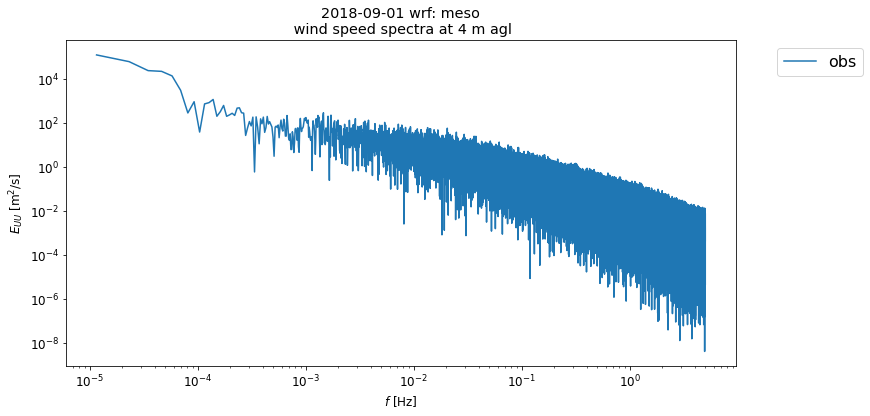

In [15]:
obs_spectra = calc_spectra(obs_ds,
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                          )

fig, ax = plt.subplots(figsize=(12, 6))

plt.rcParams.update({'font.size': 12})

# axis_font = {'fontname':'Arial', 'size':'14'}

_, ax = plot_spectrum(
        datasets={'obs': obs_spectra.to_dataframe(), 
#                   'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
#                   'edmf': edmf_spectra.sel(height=4).to_dataframe()
                 },
        fields='wspd',
        showlegend=True, fig=fig, ax=ax)

# plt.rcParams.update({'font.size': 2})

plt.title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

plt.show()

In [27]:
def plot_spectra(eval_date, sim): 

    mynn_ds, edmf_ds = read_wrf_ts(eval_date, sim)

    obs_nc = obs_dir+'sgpco2flxwind4mC1.a1/sgpco2flxwind4mC1.a1.'+eval_date.replace('-', '')+'.000000.nc'
    obs_ds = xr.open_mfdataset(obs_nc)

    obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

    if sim == 'meso': 

        obs_ds = obs_ds.sel(time=eval_date)
        mynn_ds = mynn_ds.sel(datetime=eval_date)
        edmf_ds = edmf_ds.sel(datetime=eval_date)

    else: 

        time_start = np.max([mynn_ds['datetime'].min().values, edmf_ds['datetime'].min().values, 
                             obs_ds['time'].min().values]) + les_spinup
        time_end = np.min([mynn_ds['datetime'].max().values, edmf_ds['datetime'].max().values, 
                           obs_ds['time'].max().values])

    #     print(time_start, time_end)

        obs_ds = obs_ds.sel(time=slice(time_start, time_end))
        mynn_ds = mynn_ds.sel(datetime=slice(time_start, time_end))
        edmf_ds = edmf_ds.sel(datetime=slice(time_start, time_end))

    obs_spectra = calc_spectra(obs_ds,
                          var_oi='wspd',
                          spectra_dim='time',
                          window='hamming',
                          )

    mynn_spectra = calc_spectra(mynn_ds,
                          var_oi='wspd',
                          spectra_dim='datetime',
                          level_dim='height',
                          window='hamming')

    edmf_spectra = calc_spectra(edmf_ds,
                          var_oi='wspd',
                          spectra_dim='datetime',
                          level_dim='height',
                          window='hamming')

    ax = plot_spectrum(
            datasets={'obs': obs_spectra.to_dataframe(), 
                      'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                      'edmf': edmf_spectra.sel(height=4).to_dataframe()},
            fields='wspd',
            showlegend=True)

    plt.title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

    plt.savefig('plots_03d/'+eval_date+'_'+sim+'_4m'+'_spectra.pdf')

    plt.show()

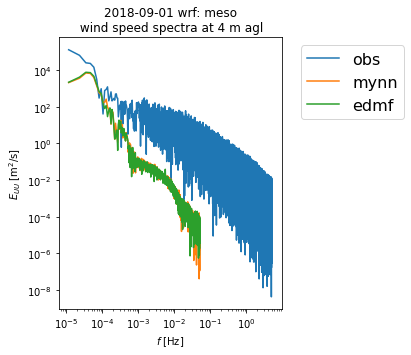

In [28]:
obs_spectra = calc_spectra(obs_ds,
                      var_oi='wspd',
                      spectra_dim='time',
                      window='hamming',
                      )

mynn_spectra = calc_spectra(mynn_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

edmf_spectra = calc_spectra(edmf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

ax = plot_spectrum(
        datasets={'obs': obs_spectra.to_dataframe(), 
                  'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                  'edmf': edmf_spectra.sel(height=4).to_dataframe()},
        fields='wspd',
        showlegend=True)

plt.title(eval_date+' wrf: '+sim+'\n wind speed spectra at 4 m agl')

plt.savefig('plots_03d/'+eval_date+'_'+sim+'_4m'+'_spectra.pdf')

plt.show()

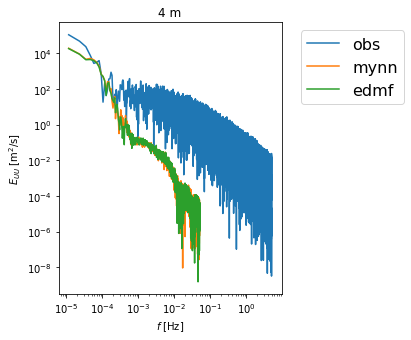

In [9]:
obs_spectra = calc_spectra(obs_ds,
                      var_oi='wspd',
                      spectra_dim='time',
                      window='hamming',
                      )

mynn_spectra = calc_spectra(mynn_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

edmf_spectra = calc_spectra(edmf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

ax = plot_spectrum(
        datasets={'obs': obs_spectra.to_dataframe(), 
                  'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                  'edmf': edmf_spectra.sel(height=4).to_dataframe()},
        fields='wspd',
        showlegend=True)

plt.title('4 m')

plt.show()

In [11]:
mynn_ds

<xarray.Dataset>
Dimensions:      (datetime: 8640, height: 2, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-05 ... 2018-08-05T23:59:50
  * height       (height) int64 4 25
  * station      (station) <U4 'z.c1'
Data variables:
    theta        (datetime, height, station) float64 310.4 310.2 ... 312.4 312.3
    pr           (datetime, height, station) float64 9.755e+04 ... 9.732e+04
    w            (datetime, height, station) float64 -0.01057 ... -0.028
    u            (datetime, height, station) float64 0.2213 0.4659 ... -0.6489
    qv           (datetime, height, station) float64 0.01209 0.01191 ... 0.01069
    v            (datetime, height, station) float64 4.882 8.049 ... 4.891 8.275
    i            (station) int64 122
    j            (station) int64 126
    lat          (station) float64 36.62
    lon          (station) float64 -97.49
    zsurface     (station) float64 306.8
    t2           (datetime, station) float64 308.2 308.2 308.2 ... 310.2 310.3
    q2           (datetime, station) float64 0.01211 0.01211 ... 0.01089 0.01089
    u10          (datetime, station) float64 0.3213 0.3168 ... -0.5808 -0.5749
    v10          (datetime, station) float64 6.414 6.413 6.412 ... 6.498 6.494
    psfc         (datetime, station) float64 9.758e+04 9.758e+04 ... 9.757e+04
    glw          (datetime, station) float64 426.2 426.3 426.3 ... 425.9 425.9
    gsw          (datetime, station) float64 192.6 183.8 183.8 ... 194.3 194.3
    hfx          (datetime, station) float64 19.7 14.62 14.71 ... 7.478 7.213
    lh           (datetime, station) float64 82.24 79.88 79.85 ... 79.07 79.04
    tsk          (datetime, station) float64 308.5 308.4 308.4 ... 310.4 310.4
    slttop       (datetime, station) float64 307.7 307.7 307.7 ... 308.8 308.8
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.02772 0.02772 ... 0.03719 0.03719
    clw          (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    cldfrac2d    (datetime, station) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 40.85 40.85 40.85 ... 33.41 33.4
    lwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp          (datetime, station) float64 6e-05 6e-05 6e-05 ... 0.0 0.0 0.0
    swp          (datetime, station) float64 0.00072 0.00073 0.00075 ... 0.0 0.0
    wp_sum       (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 6e-05 6e-05 6e-05 ... 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 3e-05 3e-05 3e-05 ... 0.0 0.0 0.0
    re_qs        (datetime, station) float64 7e-05 7e-05 7e-05 ... 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 3e-05 3e-05 3e-05 ... 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi       (datetime, station) float64 0.00496 0.00499 0.00506 ... 0.0 0.0
    tau_qs       (datetime, station) float64 0.03665 0.03746 ... 9e-05 9e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0049 0.00497 0.00499 ... 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.5978 0.5904 ... 0.609 0.609
    sza          (datetime, station) float64 73.29 73.32 

In [30]:
time_start, time_end

(numpy.datetime64('2018-08-05T00:00:00.000000000'),
 numpy.datetime64('2018-08-05T23:59:50.000000000'))

In [31]:
obs_ds_test = obs_ds.sel(time=slice(time_start, time_end))

In [32]:
obs_ds_test

<xarray.Dataset>
Dimensions:            (time: 863901)
Coordinates:
  * time               (time) datetime64[ns] 2018-08-05 ... 2018-08-05T23:59:50
Data variables:
    base_time          datetime64[ns] ...
    time_offset        (time) datetime64[ns] dask.array<chunksize=(863901,), meta=np.ndarray>
    u_wind             (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
    v_wind             (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
    w_wind             (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
    sonic_temperature  (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
    lat                float32 ...
    lon                float32 ...
    alt                float32 ...
    wspd               (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
    wdir               (time) float32 dask.array<chunksize=(863901,), meta=np.ndarray>
Attributes:
    command_line:          co2flx_ingest -n co2flx4m -s sgp -f C1
    Conventions:           ARM-1.2
    process_version:       ingest-co2flx-1.0-0.el6
    dod_version:           co2flxwind4m-a1-1.0
    input_source:          /data/collection/sgp/sgpco2flx4mC1.00/ARM-SGP-4m-2...
    site_id:               sgp
    platform_id:           co2flxwind4m
    facility_id:           C1
    data_level:            a1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    sensor_height:         4.7 m AGL
    datastream:            sgpco2flxwind4mC1.a1
    doi:                   10.5439/1258457
    history:               created by user dsmgr on machine ruby at 2018-08-0...

In [28]:
mynn_ds.sel(datetime=slice(eval_date, eval_date))

<xarray.Dataset>
Dimensions:      (datetime: 8640, height: 2, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-05 ... 2018-08-05T23:59:50
  * height       (height) int64 4 25
  * station      (station) <U4 'z.c1'
Data variables:
    theta        (datetime, height, station) float64 310.4 310.2 ... 312.4 312.3
    pr           (datetime, height, station) float64 9.755e+04 ... 9.732e+04
    w            (datetime, height, station) float64 -0.01057 ... -0.028
    u            (datetime, height, station) float64 0.2213 0.4659 ... -0.6489
    qv           (datetime, height, station) float64 0.01209 0.01191 ... 0.01069
    v            (datetime, height, station) float64 4.882 8.049 ... 4.891 8.275
    i            (station) int64 122
    j            (station) int64 126
    lat          (station) float64 36.62
    lon          (station) float64 -97.49
    zsurface     (station) float64 306.8
    t2           (datetime, station) float64 308.2 308.2 308.2 ... 310.2 310.3
    q2           (datetime, station) float64 0.01211 0.01211 ... 0.01089 0.01089
    u10          (datetime, station) float64 0.3213 0.3168 ... -0.5808 -0.5749
    v10          (datetime, station) float64 6.414 6.413 6.412 ... 6.498 6.494
    psfc         (datetime, station) float64 9.758e+04 9.758e+04 ... 9.757e+04
    glw          (datetime, station) float64 426.2 426.3 426.3 ... 425.9 425.9
    gsw          (datetime, station) float64 192.6 183.8 183.8 ... 194.3 194.3
    hfx          (datetime, station) float64 19.7 14.62 14.71 ... 7.478 7.213
    lh           (datetime, station) float64 82.24 79.88 79.85 ... 79.07 79.04
    tsk          (datetime, station) float64 308.5 308.4 308.4 ... 310.4 310.4
    slttop       (datetime, station) float64 307.7 307.7 307.7 ... 308.8 308.8
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.02772 0.02772 ... 0.03719 0.03719
    clw          (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    cldfrac2d    (datetime, station) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 40.85 40.85 40.85 ... 33.41 33.4
    lwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp          (datetime, station) float64 6e-05 6e-05 6e-05 ... 0.0 0.0 0.0
    swp          (datetime, station) float64 0.00072 0.00073 0.00075 ... 0.0 0.0
    wp_sum       (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 6e-05 6e-05 6e-05 ... 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.00078 0.00079 0.00081 ... 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 3e-05 3e-05 3e-05 ... 0.0 0.0 0.0
    re_qs        (datetime, station) float64 7e-05 7e-05 7e-05 ... 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 3e-05 3e-05 3e-05 ... 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi       (datetime, station) float64 0.00496 0.00499 0.00506 ... 0.0 0.0
    tau_qs       (datetime, station) float64 0.03665 0.03746 ... 9e-05 9e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0049 0.00497 0.00499 ... 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.5978 0.5904 ... 0.609 0.609
    sza          (datetime, station) float64 73.29 73.32 

In [25]:
obs_spectra = calc_spectra(obs_ds,
                      var_oi='wspd',
                      spectra_dim='time',
                      window='hamming',
                      )

mynn_spectra = calc_spectra(mynn_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

edmf_spectra = calc_spectra(edmf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

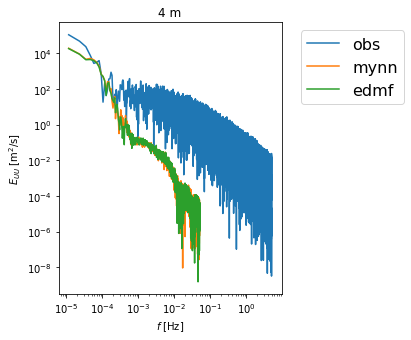

In [26]:
obs_spectra = calc_spectra(obs_ds,
                      var_oi='wspd',
                      spectra_dim='time',
                      window='hamming',
                      )

mynn_spectra = calc_spectra(mynn_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

edmf_spectra = calc_spectra(edmf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming')

ax = plot_spectrum(
        datasets={'obs': obs_spectra.to_dataframe(), 
                  'mynn': mynn_spectra.sel(height=4).to_dataframe(), 
                  'edmf': edmf_spectra.sel(height=4).to_dataframe()},
        fields='wspd',
        showlegend=True)

plt.title('4 m')

plt.show()

In [23]:
eval_date.replace('-', '')

'20180805'

In [5]:
data_dir_df['2018-08-05']

mynn              l1_0805m
edmf              l2_0805e
mynn_1arcs        l5_0805m
wrf_start     8/4/18 12:00
Name: 2018-08-05, dtype: object

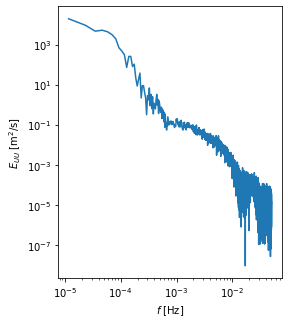

In [12]:
wrf_spectra = calc_spectra(wrf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
#                       average_dim='station',
                      level_dim='height',
                      window='hamming',
#                       tstart=pd.to_datetime(tstart),
#                       interval='10s',
#                       window_length=window_length,
#                       window_overlap_pct=window_overlap_pct 
                      #level=[0,1]
                      )

ax = plot_spectrum(
        datasets={'test':wrf_spectra.sel(height=4).to_dataframe(), \
                  },
        #height=80,
        #times=spectraTimes,
        fields='wspd',
#         freqlimits=(1e-3,1),
#         fieldlimits={'wspd':(1e-3,1e2)},
        showlegend=False,
    )

In [7]:
obs_nc = obs_dir+'sgpco2flxwind4mC1.a1/sgpco2flxwind4mC1.a1.20180805.000000.nc'
obs_ds = xr.open_mfdataset(obs_nc)

obs_ds['wspd'], obs_ds['wdir'] = calc_wind(obs_ds, u='u_wind', v='v_wind')

In [8]:
obs_ds

<xarray.Dataset>
Dimensions:            (time: 864000)
Coordinates:
  * time               (time) datetime64[ns] 2018-08-05 ... 2018-08-05T23:59:...
Data variables:
    base_time          datetime64[ns] ...
    time_offset        (time) datetime64[ns] dask.array<chunksize=(864000,), meta=np.ndarray>
    u_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    v_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    w_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    sonic_temperature  (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    lat                float32 ...
    lon                float32 ...
    alt                float32 ...
    wspd               (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    wdir               (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
Attributes:
    command_line:          co2flx_ingest -n co2flx4m -s sgp -f C1
    Conventions:           ARM-1.2
    process_version:       ingest-co2flx-1.0-0.el6
    dod_version:           co2flxwind4m-a1-1.0
    input_source:          /data/collection/sgp/sgpco2flx4mC1.00/ARM-SGP-4m-2...
    site_id:               sgp
    platform_id:           co2flxwind4m
    facility_id:           C1
    data_level:            a1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    sensor_height:         4.7 m AGL
    datastream:            sgpco2flxwind4mC1.a1
    doi:                   10.5439/1258457
    history:               created by user dsmgr on machine ruby at 2018-08-0...

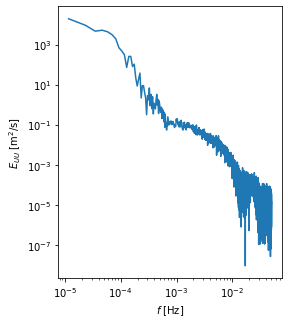

In [16]:
obs_spectra = calc_spectra(obs_ds,
                      var_oi='wspd',
                      spectra_dim='time',
#                       average_dim='station',
#                       level_dim='height',
                      window='hamming',
#                       tstart=pd.to_datetime(tstart),
#                       interval='10s',
#                       window_length=window_length,
#                       window_overlap_pct=window_overlap_pct 
                      #level=[0,1]
                      )

# ax = plot_spectrum(
#         datasets={'test':wrf_spectra.sel(height=4).to_dataframe(), \
#                   },
#         #height=80,
#         #times=spectraTimes,
#         fields='wspd',
# #         freqlimits=(1e-3,1),
# #         fieldlimits={'wspd':(1e-3,1e2)},
#         showlegend=False,
#     )

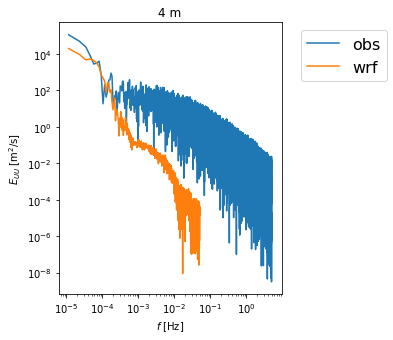

In [20]:
ax = plot_spectrum(
        datasets={'obs':obs_spectra.to_dataframe(), \
                  'wrf':wrf_spectra.sel(height=4).to_dataframe()},
        #height=80,
        #times=spectraTimes,
        fields='wspd',
#         freqlimits=(1e-3,1),
#         fieldlimits={'wspd':(1e-3,1e2)},
        showlegend=True,
    )

plt.title('4 m')

plt.show()

In [10]:
obs_spectra

<xarray.Dataset>
Dimensions:    (frequency: 432001)
Coordinates:
  * frequency  (frequency) float64 0.0 1.157e-05 2.315e-05 ... 5.0 5.0 5.0
Data variables:
    wspd       (frequency) float32 1.026e+04 1.129e+05 ... 0.0004931 2.001e-05

In [13]:
wrf_spectra

<xarray.Dataset>
Dimensions:    (frequency: 4321, height: 2)
Coordinates:
  * height     (height) int64 4 25
  * frequency  (frequency) float64 0.0 1.157e-05 2.315e-05 ... 0.04999 0.05
Data variables:
    wspd       (height, frequency) float64 4.524e+03 1.973e+04 ... 1.597e-06

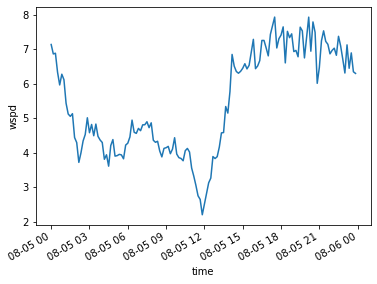

In [52]:
obs_ds['wspd'].resample(time='10min').mean().plot()

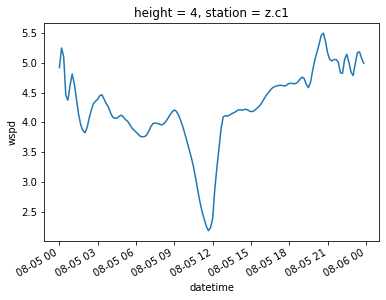

In [51]:
wrf_ds['wspd'].sel(height=4, datetime='2018-08-05').resample(datetime='10min').mean().plot()

In [32]:
obs_ds

<xarray.Dataset>
Dimensions:            (time: 864000)
Coordinates:
  * time               (time) datetime64[ns] 2018-08-05 ... 2018-08-05T23:59:...
Data variables:
    base_time          datetime64[ns] ...
    time_offset        (time) datetime64[ns] dask.array<chunksize=(864000,), meta=np.ndarray>
    u_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    v_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    w_wind             (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    sonic_temperature  (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    lat                float32 ...
    lon                float32 ...
    alt                float32 ...
    wspd               (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
    wdir               (time) float32 dask.array<chunksize=(864000,), meta=np.ndarray>
Attributes:
    command_line:          co2flx_ingest -n co2flx4m -s sgp -f C1
    Conventions:           ARM-1.2
    process_version:       ingest-co2flx-1.0-0.el6
    dod_version:           co2flxwind4m-a1-1.0
    input_source:          /data/collection/sgp/sgpco2flx4mC1.00/ARM-SGP-4m-2...
    site_id:               sgp
    platform_id:           co2flxwind4m
    facility_id:           C1
    data_level:            a1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    sensor_height:         4.7 m AGL
    datastream:            sgpco2flxwind4mC1.a1
    doi:                   10.5439/1258457
    history:               created by user dsmgr on machine ruby at 2018-08-0...

In [26]:
wrf_ds

<xarray.Dataset>
Dimensions:      (datetime: 12960, height: 2, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-04T12:00:10 ... 2018-08-06
  * height       (height) int64 4 25
  * station      (station) <U4 'z.c1'
Data variables:
    theta        (datetime, height, station) float64 299.7 299.8 ... 312.4 312.3
    pr           (datetime, height, station) float64 9.788e+04 ... 9.732e+04
    w            (datetime, height, station) float64 -0.01089 ... -0.02726
    u            (datetime, height, station) float64 -0.8431 -0.9107 ... -0.6443
    qv           (datetime, height, station) float64 0.0101 0.01004 ... 0.01069
    v            (datetime, height, station) float64 5.54 6.123 ... 4.888 8.271
    i            (station) int64 122
    j            (station) int64 126
    lat          (station) float64 36.62
    lon          (station) float64 -97.49
    zsurface     (station) float64 306.8
    t2           (datetime, station) float64 298.0 297.9 297.9 ... 310.3 310.2
    q2           (datetime, station) float64 0.01009 0.0101 ... 0.01089 0.01089
    u10          (datetime, station) float64 -0.909 -0.9003 ... -0.5749 -0.5695
    v10          (datetime, station) float64 6.022 5.879 5.69 ... 6.494 6.49
    psfc         (datetime, station) float64 9.791e+04 9.791e+04 ... 9.757e+04
    glw          (datetime, station) float64 376.0 376.0 376.0 ... 425.9 425.9
    gsw          (datetime, station) float64 21.27 21.27 21.27 ... 194.3 194.3
    hfx          (datetime, station) float64 -28.8 -33.22 -32.78 ... 7.213 7.407
    lh           (datetime, station) float64 16.39 16.18 16.12 ... 79.04 79.04
    tsk          (datetime, station) float64 297.5 297.3 297.3 ... 310.4 310.4
    slttop       (datetime, station) float64 301.3 301.3 301.3 ... 308.8 308.8
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.0 0.0 0.0 ... 0.03719 0.03719
    clw          (datetime, station) float64 0.00028 0.00122 0.00158 ... 0.0 0.0
    cldfrac2d    (datetime, station) float64 0.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 37.1 37.1 37.1 ... 33.41 33.4 33.4
    lwp          (datetime, station) float64 0.00028 0.0012 0.00156 ... 0.0 0.0
    iwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_sum       (datetime, station) float64 0.00028 0.0012 0.00156 ... 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.00028 0.0012 ... 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.0 0.00028 0.0012 ... 0.0 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qs        (datetime, station) float64 0.0 0.0 0.0 ... 4e-05 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.1403 0.4654 0.5659 ... 0.0 0.0
    tau_qi       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qs       (datetime, station) float64 0.0 0.0 0.0 ... 9e-05 9e-05 9e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.09879 0.429 ... 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.3451 0.3451 ... 0.609 0.609
    sza          (datetime, station) float64 86.8 86.

In [43]:
spectra

<xarray.Dataset>
Dimensions:    (frequency: 6481, height: 2, station: 1)
Coordinates:
  * height     (height) int64 4 25
  * frequency  (frequency) float64 0.0 7.716e-06 1.543e-05 ... 0.04999 0.05
  * station    (station) <U4 'z.c1'
Data variables:
    wspd       (height, station, frequency) float64 4.612e+03 ... 3.265e-05

In [2]:
c1_file_path = wrf_runs_dir+'l1_0805m/z_ts/z.c1.d04'
# c1_file_path = wrf_dir+'z_ts/z.'+sim_dict[model][0]
wrf_tower = Tower(c1_file_path)

# # simulation start time
wrf_start = '8/4/18 12:00'

def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, d04_wrf_dt)

wrf_ds['wspd'], wrf_ds['wdir'] = calc_wind(wrf_ds)

In [3]:
wrf_ds

<xarray.Dataset>
Dimensions:      (datetime: 81000, height: 2, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-05T15:00:00.400000 ... 201...
  * height       (height) int64 4 25
  * station      (station) <U4 'z.c1'
Data variables:
    w            (datetime, height, station) float64 -0.01046 ... -0.06639
    v            (datetime, height, station) float64 2.807 6.627 ... 3.663 8.823
    u            (datetime, height, station) float64 0.6833 2.253 ... -0.4742
    theta        (datetime, height, station) float64 306.2 304.9 ... 312.5 312.3
    pr           (datetime, height, station) float64 9.798e+04 ... 9.728e+04
    qv           (datetime, height, station) float64 0.01482 0.01449 ... 0.01061
    i            (station) int64 115
    j            (station) int64 270
    lat          (station) float64 36.61
    lon          (station) float64 -97.49
    zsurface     (station) float64 310.6
    t2           (datetime, station) float64 304.5 304.4 304.4 ... 310.3 310.3
    q2           (datetime, station) float64 0.01487 0.01487 ... 0.01084 0.01084
    u10          (datetime, station) float64 1.039 1.052 ... -0.4232 -0.4171
    v10          (datetime, station) float64 4.065 4.061 4.06 ... 5.461 5.46
    psfc         (datetime, station) float64 9.8e+04 9.8e+04 ... 9.752e+04
    glw          (datetime, station) float64 402.0 402.0 402.0 ... 425.6 425.6
    gsw          (datetime, station) float64 491.2 491.2 491.2 ... 187.9 187.9
    hfx          (datetime, station) float64 218.8 200.0 201.1 ... 18.66 18.68
    lh           (datetime, station) float64 108.9 103.7 104.3 ... 68.21 68.18
    tsk          (datetime, station) float64 310.1 309.5 309.3 ... 310.7 310.7
    slttop       (datetime, station) float64 300.8 300.8 300.8 ... 310.4 310.4
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.03828 0.03828 ... 0.03828 0.03828
    clw          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cldfrac2d    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 36.01 36.01 36.01 ... 33.64 33.65
    lwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_sum       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qs        (datetime, station) float64 3e-05 3e-05 3e-05 ... 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qs       (datetime, station) float64 1e-05 1e-05 1e-05 ... 8e-05 8e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.7149 0.7149 ... 0.6078 0.6078
    sza          (datetime, station) float64 

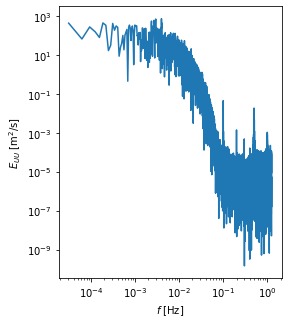

In [4]:
spectra = calc_spectra(wrf_ds,
                      var_oi='wspd',
                      spectra_dim='datetime',
                      average_dim='station',
                      level_dim='height',
                      window='hamming',
#                       tstart=pd.to_datetime(tstart),
#                       interval='10s',
#                       window_length=window_length,
#                       window_overlap_pct=window_overlap_pct 
                      #level=[0,1]
                      )

ax = plot_spectrum(
        datasets={'test':spectra.sel(height=4).to_dataframe(), \
                  },
        #height=80,
        #times=spectraTimes,
        fields='wspd',
#         freqlimits=(1e-3,1),
#         fieldlimits={'wspd':(1e-3,1e2)},
        showlegend=False,
    )

In [3]:
data_dir_df

2018-08-05     2018-09-01
mynn            l1_0805m       l3_0901m
edmf            l2_0805e       l4_0901e
mynn_1arcs      l5_0805m            NaN
wrf_start   8/4/18 12:00  8/31/18 12:00

In [5]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

def plot_flux(eval_date, row, model):

    date_col = data_dir_df[eval_date]

#     wrf_mynn_dir = wrf_runs_dir+date_col['mynn']+'/'
#     c1_mynn_file_path = wrf_mynn_dir+c1_file_name
    
    wrf_dir = wrf_runs_dir+date_col[row]+'/'
    c1_file_path = wrf_dir+'z_ts/z.'+sim_dict[model][0]
    wrf_tower = Tower(c1_file_path)

    # # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, sim_dict[model][1])

    wrf_ds = wrf_ds.sel(datetime=slice(eval_date, eval_date))

    co2flx25m_ds = co2flx25m.sel(time=slice(eval_date, eval_date))
    co2flx4m_ds = co2flx4m.sel(time=slice(eval_date, eval_date))

    for wrf_var, var in co2flx25m_dict.items(): 
        
#         print(wrf_ds['datetime'])
#         print(co2flx25m_ds['time'])

        plt.plot(wrf_ds['datetime'], wrf_ds[wrf_var], label='wrf')
        plt.plot(co2flx25m_ds['time'], co2flx25m_ds[var[0]], label='co2flx25m')

        plt.title(var[0]+': '+row+' '+model+' vs '+co2flx25m_ds.platform_id+': '+eval_date)
        plt.ylabel(var[1])
        plt.axhline(color='grey', linestyle='--')
        plt.tick_params(labelrotation=90)
        plt.legend()

        plt.savefig('plots_03c/'+eval_date+'_'+row+'_'+model+'_'+wrf_var+'.pdf')

        plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for var, ax_i in zip(co2flx4m_dict.items(), ax): 

        ax_i.plot(wrf_ds['datetime'], wrf_ds[var[0]], label='wrf')
        ax_i.plot(co2flx4m_ds['time'], co2flx4m_ds[var[1][0]], label='co2flx4m')

        ax_i.set_title(var[1][0]+': '+row+' '+model+' vs '
                       +co2flx4m_ds.platform_id+': '+eval_date)
        ax_i.set_ylabel(var[1][1])
        ax_i.axhline(color='grey', linestyle='--')
        ax_i.tick_params(labelrotation=90)
        ax_i.legend()

    p2_txt = '_'.join([str(elem) for elem in list(co2flx4m_dict.keys())])    

    plt.savefig('plots_03c/'+eval_date+'_'+row+'_'+model+'_'+p2_txt+'.pdf')

    plt.show()
    
    return wrf_ds

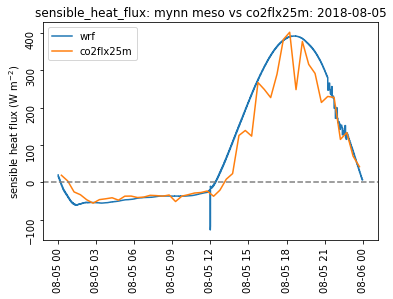

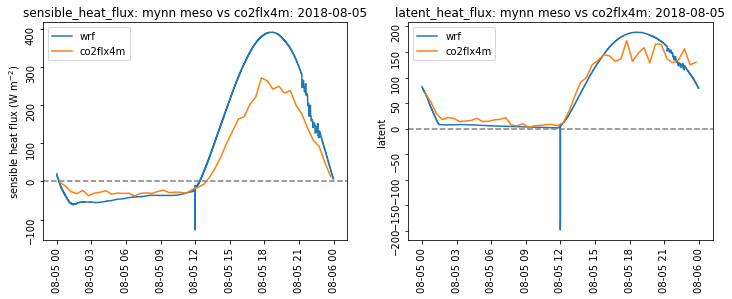

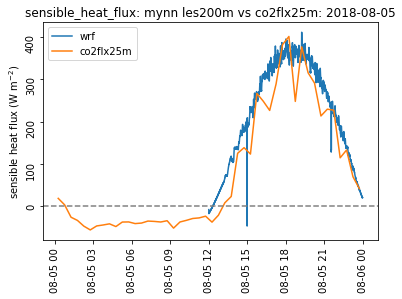

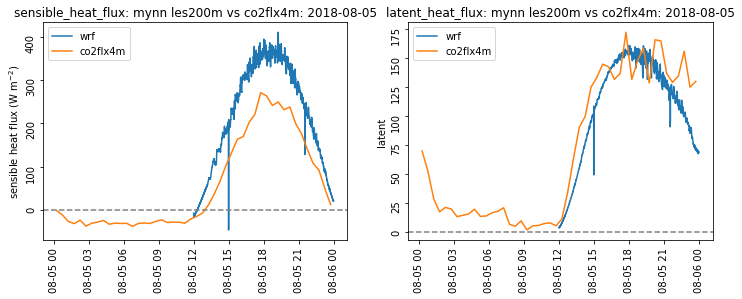

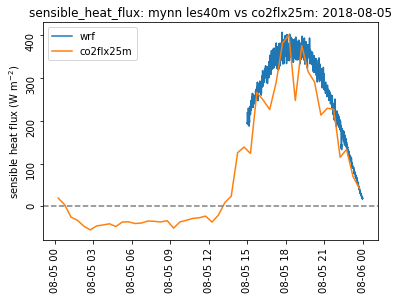

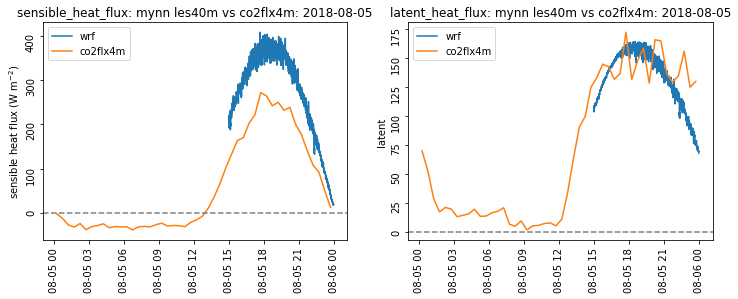

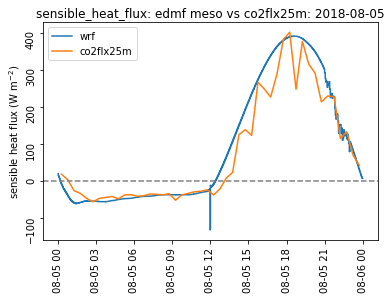

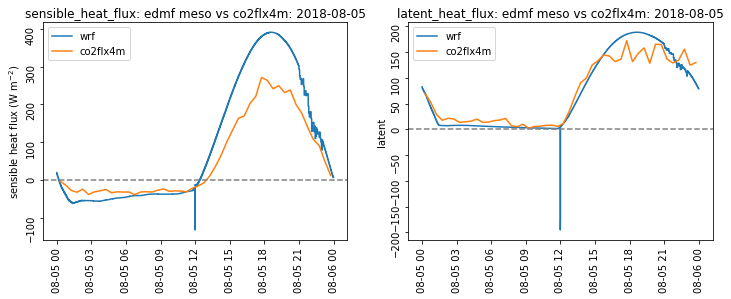

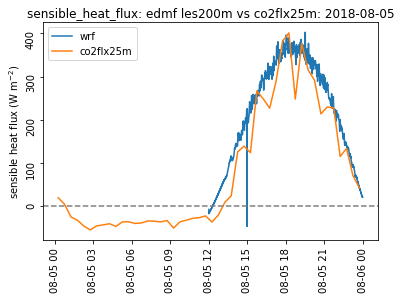

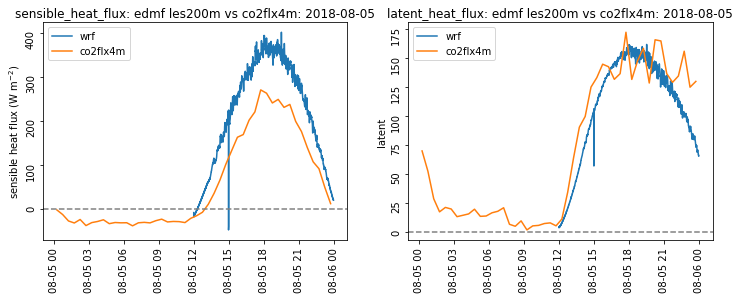

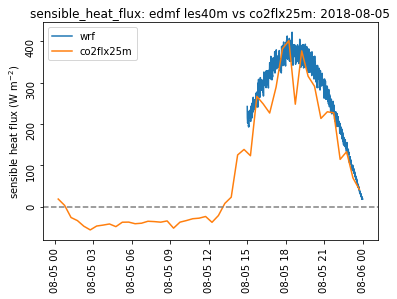

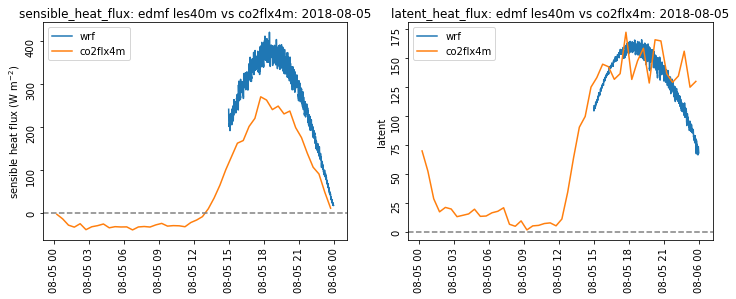

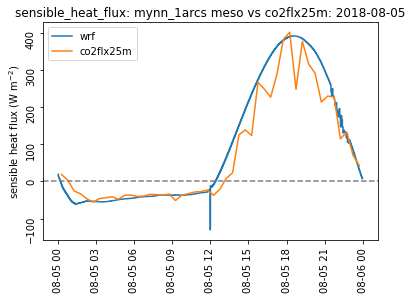

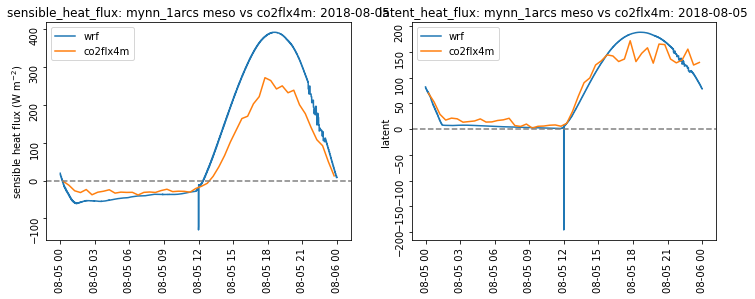

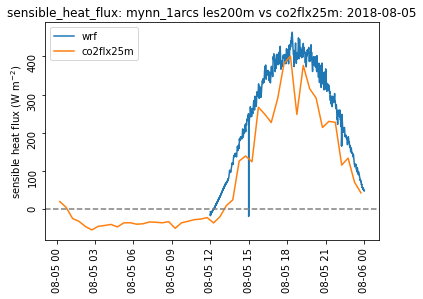

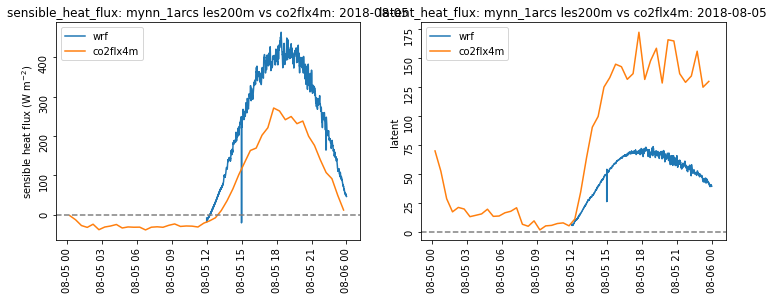

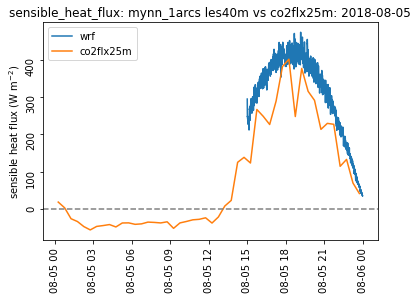

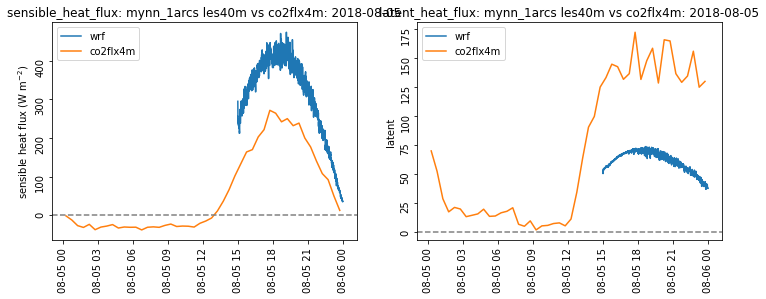

In [36]:
eval_date = '2018-08-05'
for row in ['mynn', 'edmf', 'mynn_1arcs']: 
    for model in sim_dict.keys():
        plot_flux(eval_date, row, model)

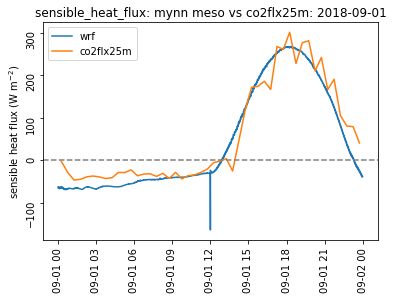

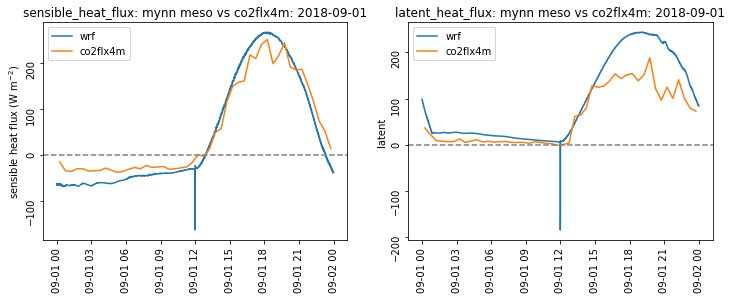

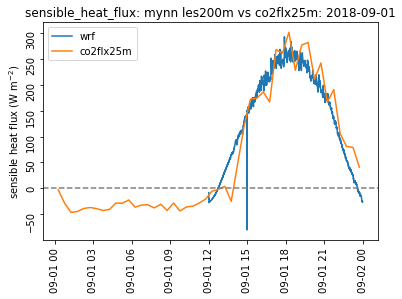

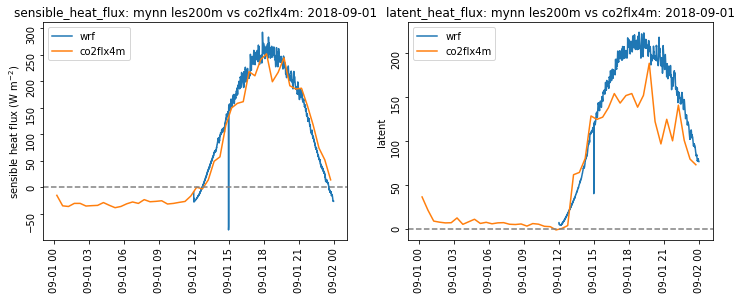

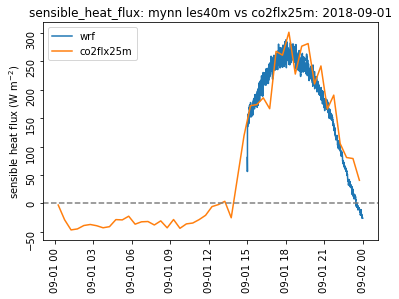

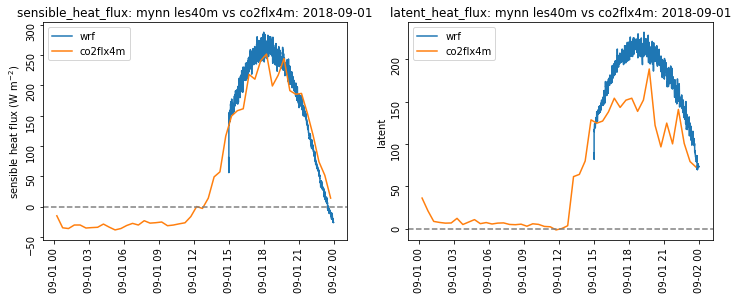

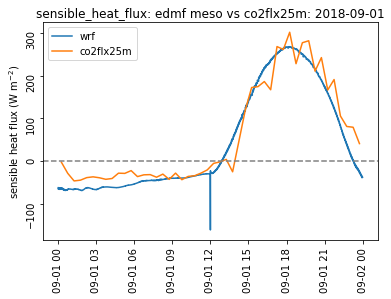

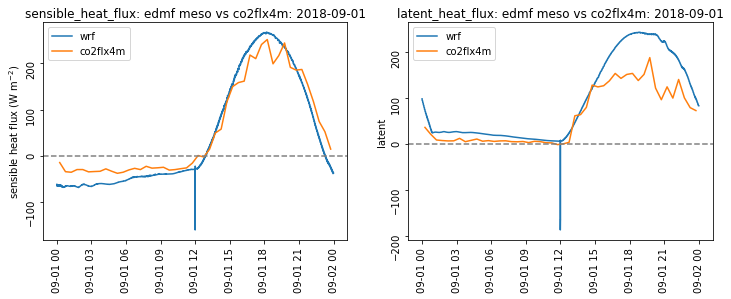

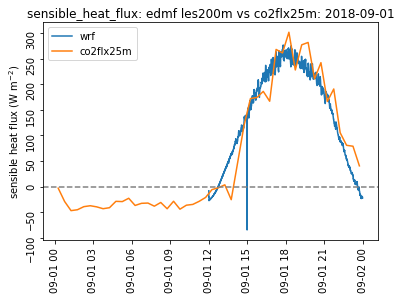

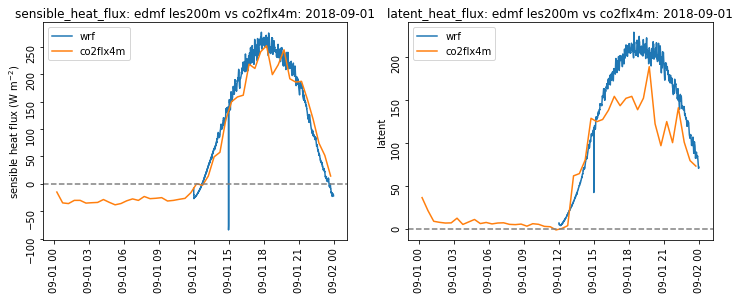

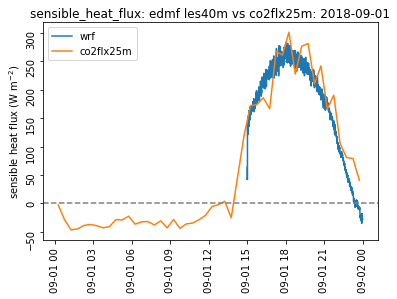

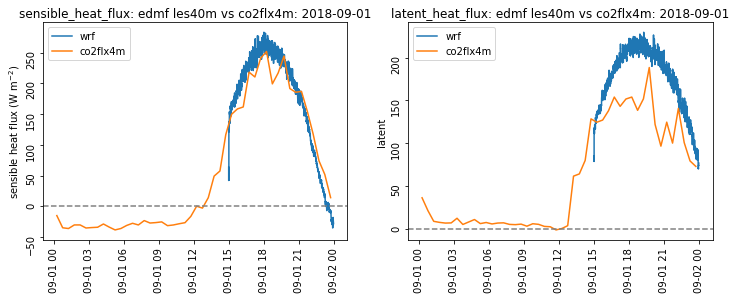

In [6]:
eval_date = '2018-09-01'
for row in ['mynn', 'edmf']: 
    for model in sim_dict.keys():
        plot_flux(eval_date, row, model)

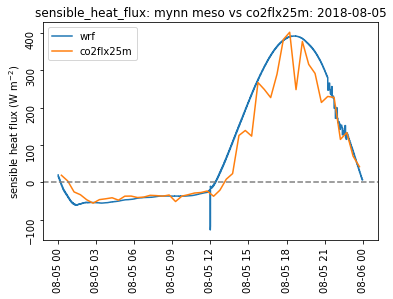

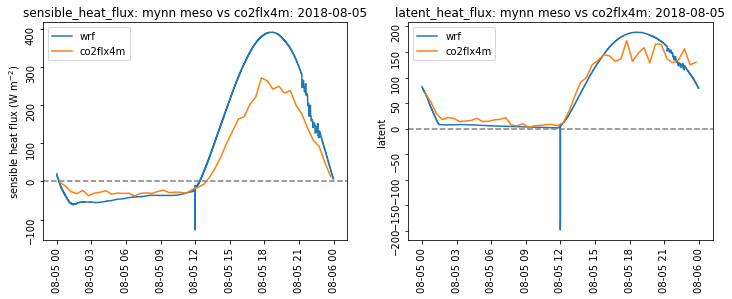

In [18]:
eval_date = '2018-08-05'
mm = plot_flux(eval_date, 'mynn', 'meso')

In [29]:
# checked TS file, hfx IS that odd... starting the inner domain causes the problem??
mm['hfx'].sel(datetime=slice('2018-08-05T11:58', '2018-08-05T12:02'))

<xarray.DataArray 'hfx' (datetime: 30, station: 1)>
array([[ -19.49589],
       [ -19.5514 ],
       [ -19.5992 ],
       [ -19.64952],
       [ -19.70514],
       [ -19.7481 ],
       [ -19.79265],
       [ -19.84283],
       [-127.10773],
       [-116.67835],
       [-117.7855 ],
       [-118.25767],
       [-117.96146],
       [ -10.34582],
       [ -11.78806],
       [ -12.14938],
       [ -12.42465],
       [ -12.70046],
       [ -12.95655],
       [ -13.19956],
       [ -13.43283],
       [ -13.62916],
       [ -13.83105],
       [ -14.02229],
       [ -14.21196],
       [ -14.37398],
       [ -14.54752],
       [ -14.70349],
       [ -14.85901],
       [ -15.00641]])
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-05T11:58:00 ... 2018-08-05T12...
  * station   (station) <U4 'z.c1'